（1）正在读取Excel文件...
 -> 数据参数准备完成。

--- 开始执行遗传算法 (情景: waste) ---


进化中: 100%|██████████| 200/200 [01:12<00:00,  2.74it/s]


--- 遗传算法优化完成 ---

情景 waste 求解完成。
 -> 最优7年总利润: 29,876,451.25 元

--- 开始执行遗传算法 (情景: discount) ---


进化中: 100%|██████████| 200/200 [01:14<00:00,  2.69it/s]

--- 遗传算法优化完成 ---

情景 discount 求解完成。
 -> 最优7年总利润: 43,230,758.62 元
情景 waste 的最优方案已保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\result1_waste.xlsx
情景 discount 的最优方案已保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\result1_discount.xlsx

所有求解任务完成！


--- 正在生成情景 'waste' 的收敛曲线 ---
收敛曲线图已成功保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\convergence_waste.png


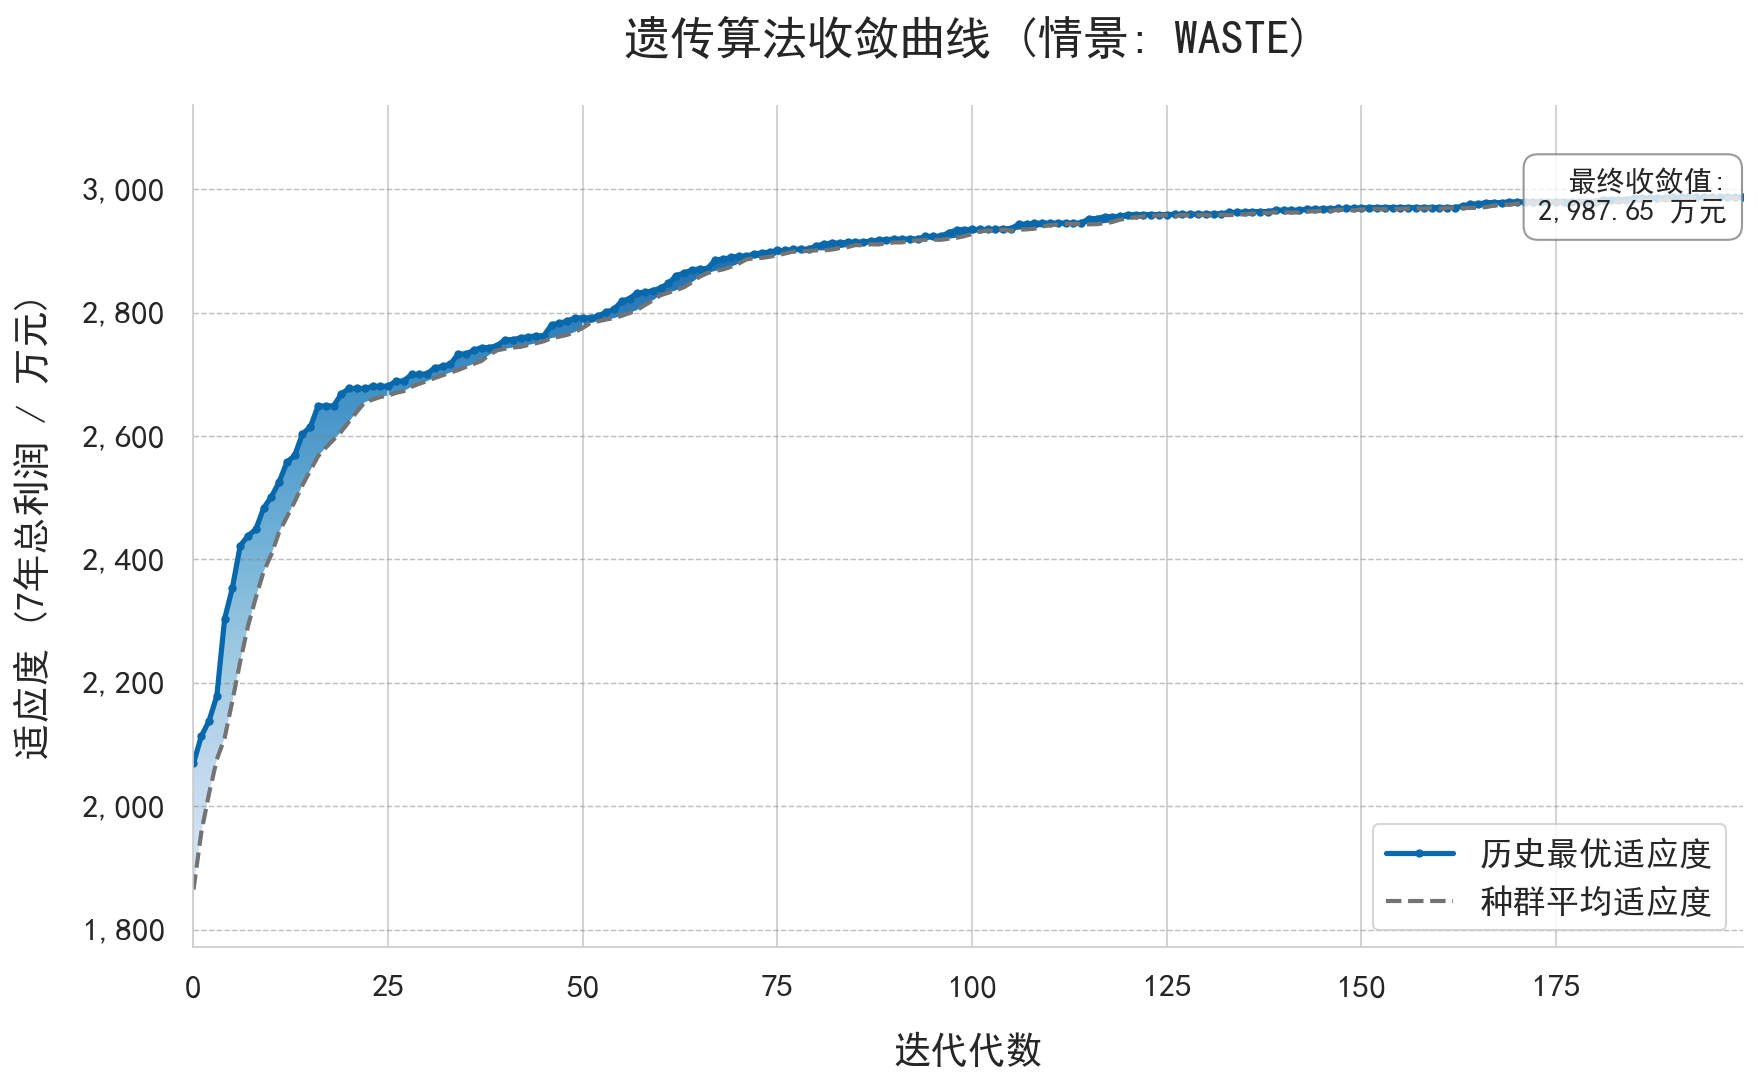


--- 正在生成情景 'discount' 的收敛曲线 ---
收敛曲线图已成功保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\convergence_discount.png


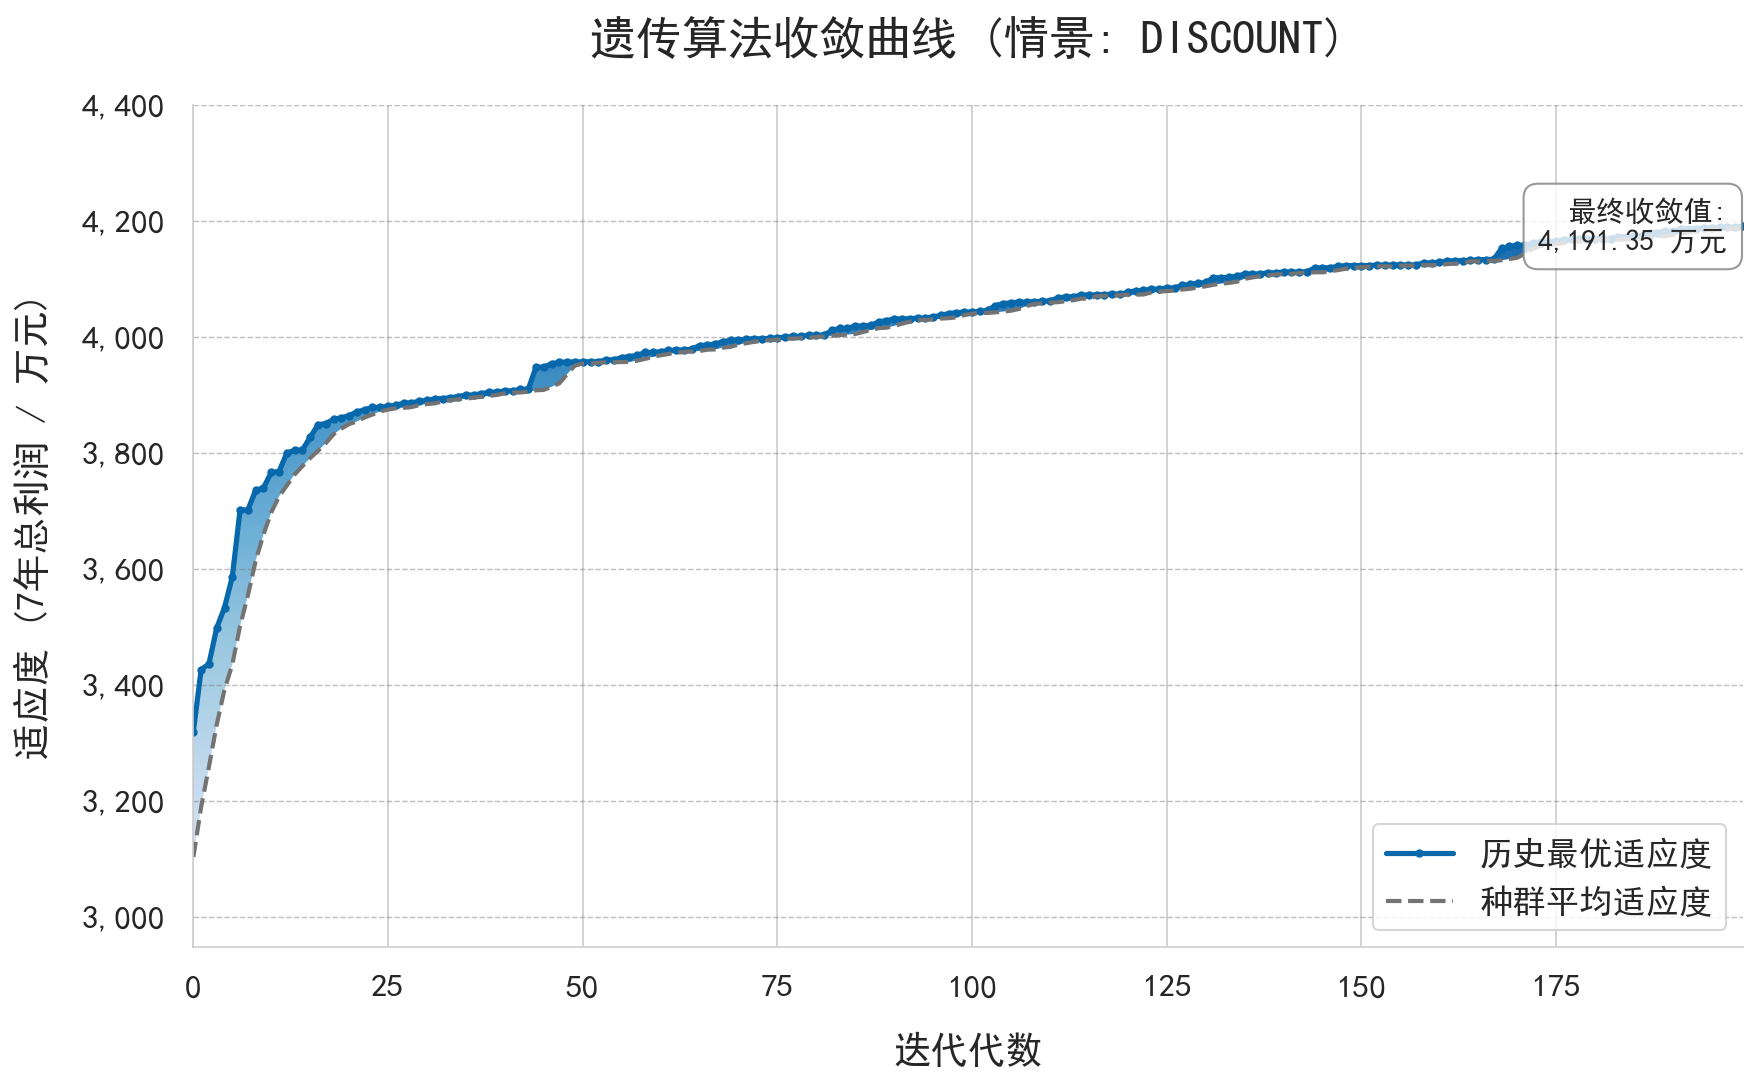

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib.transforms import TransformedPath
from matplotlib.ticker import FuncFormatter

def plot_convergence_final_style(log_path, output_path, scenario):
    """
    绘制最终风格的遗传算法收敛曲线图。
    """
    # --- 1. 设置字体与全局样式 ---
    plt.rcParams['font.family'] = 'SimHei'
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.size'] = 16

    try:
        df = pd.read_csv(log_path)
    except FileNotFoundError:
        print(f"警告: 日志文件 {log_path} 未找到，无法绘图。")
        return

    # --- 2. 绘制收敛曲线图 ---
    fig, ax = plt.subplots(figsize=(12, 7.5), dpi=150)

    # 绘制曲线
    color_best = '#0868ac' # 专业蓝
    color_avg = '#737373'  # 中性灰
    ax.plot(df['Generation'], df['Best_Fitness'], color=color_best, linewidth=2.5, marker='o', markersize=3, label='历史最优适应度')
    ax.plot(df['Generation'], df['Average_Fitness'], color=color_avg, linewidth=2.0, linestyle='--', label='种群平均适应度')

    # --- 3. 实现上下渐变色填充 ---
    cmap = plt.get_cmap('Blues') 
    gradient_fill_colors = cmap(np.linspace(0.1, 0.9, 256))
    gradient_fill_cmap = plt.matplotlib.colors.ListedColormap(gradient_fill_colors)

    # 使用imshow创建渐变背景，并用曲线区域进行裁剪
    z = np.linspace(0, 1, 256).reshape(256, 1)
    y_min, y_max = ax.get_ylim()
    # 扩展y轴范围以确保渐变完全覆盖
    ax.set_ylim(bottom=df['Average_Fitness'].min() * 0.95, top=df['Best_Fitness'].max() * 1.05)
    y_min, y_max = ax.get_ylim()

    im = ax.imshow(z, aspect='auto', origin='lower', extent=[df['Generation'].min(), df['Generation'].max(), y_min, y_max], cmap=gradient_fill_cmap, zorder=0)

    path_data = np.array([
        df['Generation'].tolist() + df['Generation'].tolist()[::-1], 
        df['Average_Fitness'].tolist() + df['Best_Fitness'].tolist()[::-1]
    ]).transpose()
    path = plt.matplotlib.path.Path(path_data)
    clip_path = TransformedPath(path, ax.transData)
    im.set_clip_path(clip_path)

    # --- 4. 格式化与美化 ---
    ax.set_title(f'遗传算法收敛曲线 (情景: {scenario.upper()})', fontsize=22, pad=25, weight='bold')
    ax.set_xlabel('迭代代数', fontsize=18, labelpad=15)
    ax.set_ylabel('适应度 (7年总利润 / 万元)', fontsize=18, labelpad=15)

    ax.grid(True, axis='y', linestyle='--', linewidth=0.7, color='grey', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    ax.legend(loc='lower right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
    
    # 格式化Y轴为“万元”
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y/1e4:,.0f}'))

    # 在曲线末端添加最终值注释
    final_value = df['Best_Fitness'].iloc[-1]
    ax.text(df['Generation'].iloc[-1] - 2, final_value, f'最终收敛值:\n{final_value/1e4:,.2f} 万元',
            ha='right', va='center', fontsize=14,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", lw=1, alpha=0.8))

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    print(f"收敛曲线图已成功保存至: {output_path}")
    plt.show()


if __name__ == '__main__':
    current_dir = Path.cwd()
    output_dir = current_dir / '..' / 'Result'

    # 定义文件路径
    log_path_waste = output_dir / 'ga_log_waste.csv'
    plot_path_waste = output_dir / 'convergence_waste.png'
    log_path_discount = output_dir / 'ga_log_discount.csv'
    plot_path_discount = output_dir / 'convergence_discount.png'

    # 分别调用绘图函数
    print("--- 正在生成情景 'waste' 的收敛曲线 ---")
    plot_convergence_final_style(log_path_waste, plot_path_waste, 'waste')

    print("\n--- 正在生成情景 'discount' 的收敛曲线 ---")
    plot_convergence_final_style(log_path_discount, plot_path_discount, 'discount')

（1）正在读取Excel文件...
 -> 数据参数准备完成。

正在对参数 p 进行灵敏度分析...


测试不同的p值:  25%|██▌       | 1/4 [01:05<03:16, 65.60s/it]

p = 1 时，最优利润 = 4,888,140.88 元


测试不同的p值:  50%|█████     | 2/4 [02:17<02:18, 69.44s/it]

p = 2 时，最优利润 = 42,876,491.62 元


测试不同的p值:  75%|███████▌  | 3/4 [04:11<01:29, 89.72s/it]

p = 3 时，最优利润 = 42,972,886.62 元


测试不同的p值: 100%|██████████| 4/4 [06:12<00:00, 93.06s/it] 


p = 4 时，最优利润 = 42,367,421.25 元

正在对参数 q 进行灵敏度分析...


测试不同的q值:  25%|██▌       | 1/4 [01:46<05:18, 106.04s/it]

q = 2 时，最优利润 = 42,084,435.00 元


测试不同的q值:  50%|█████     | 2/4 [03:32<03:32, 106.38s/it]

q = 3 时，最优利润 = 42,532,157.88 元


测试不同的q值:  75%|███████▌  | 3/4 [04:56<01:36, 96.24s/it] 

q = 4 时，最优利润 = 43,034,533.12 元


测试不同的q值: 100%|██████████| 4/4 [06:15<00:00, 93.91s/it]

q = 5 时，最优利润 = 42,865,075.75 元



灵敏度分析图像已保存至: c:\Users\86185\Desktop\2024C\3问题一\..\Result\sensitivity_p_q.png


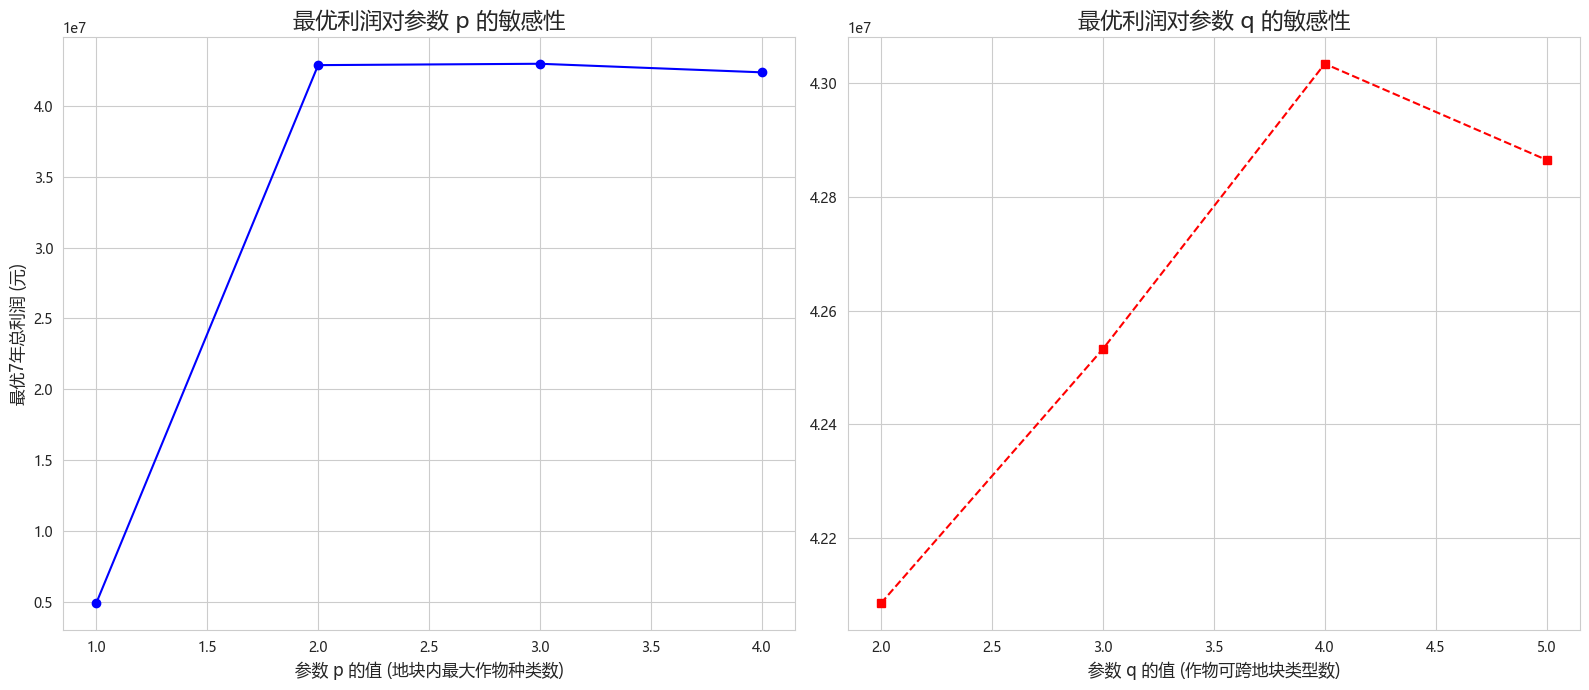


所有分析任务完成！


In [ ]:
# -*- coding: utf-8 -*-
# 文件名: final_sensitivity_analysis.py
# 功能: 基于修复式遗传算法，对参数p和q进行灵敏度分析
# 版本: Final_Corrected

import pandas as pd
import numpy as np
import os
import re
import random
import copy
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 分析与算法配置区 ---
# 灵敏度分析参数范围
P_VALUES_TO_TEST = [1, 2, 3, 4]
Q_VALUES_TO_TEST = [2, 3, 4, 5]
DEFAULT_P = 2
DEFAULT_Q = 3

# GA参数
POP_SIZE = 100
MAX_GEN = 200 # 为确保收敛，建议使用稍大的代数
CX_PROB = 0.8
MUT_PROB = 0.2
TOURNAMENT_SIZE = 3
ELITISM_SIZE = 5

# [修正] 惩罚权重 (只惩罚p和q，因为其他约束已被修复)
MAX_PROFIT_PER_ACRE = 300000 
W_DIVERSITY_P = MAX_PROFIT_PER_ACRE * 2
W_DIVERSITY_Q = MAX_PROFIT_PER_ACRE * 2

# --- 2. 核心功能函数 ---

def load_and_prepare_data(data_path):
    # (此函数内容与上一版完全相同)
    try:
        print("（1）正在读取Excel文件...")
        path_f1 = os.path.join(data_path, '附件1.xlsx'); path_f2 = os.path.join(data_path, '附件2.xlsx')
        plots_df = pd.read_excel(path_f1, sheet_name='乡村的现有耕地'); crops_info_df = pd.read_excel(path_f1, sheet_name='乡村种植的农作物')
        stats_df = pd.read_excel(path_f2, sheet_name='2023年统计的相关数据'); past_planting_df = pd.read_excel(path_f2, sheet_name='2023年的农作物种植情况')
        for df in [plots_df, crops_info_df, stats_df, past_planting_df]: df.columns = df.columns.str.strip()
        params = {}; params['I_plots'] = sorted(plots_df['地块名称'].tolist()); params['J_crops'] = sorted(crops_info_df['作物名称'].dropna().unique().tolist())
        params['P_area'] = dict(zip(plots_df['地块名称'], plots_df['地块面积/亩'])); params['P_plot_type'] = dict(zip(plots_df['地块名称'], plots_df['地块类型']))
        params['P_crop_type'] = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型'])); bean_keywords = ['豆', '豆类']; params['J_bean'] = [j for j, ctype in params['P_crop_type'].items() if isinstance(ctype, str) and '豆' in ctype]
        params['P_past'] = {i: {1: None, 2: None} for i in params['I_plots']}
        for _, row in past_planting_df.iterrows():
            plot, crop = row['种植地块'], row['作物名称']; season = row.get('种植季节', 1) 
            if plot in params['I_plots']: params['P_past'][plot][season] = crop
        def clean_and_convert_price(value):
            if isinstance(value, str) and any(c in value for c in '-–—'):
                parts = re.split(r'[-–—]', value.strip());
                try: return (float(parts[0]) + float(parts[1])) / 2
                except (ValueError, IndexError): return np.nan
            return pd.to_numeric(value, errors='coerce')
        stats_df['销售单价/(元/斤)'] = stats_df['销售单价/(元/斤)'].apply(clean_and_convert_price); stats_df['亩产量/斤'] = pd.to_numeric(stats_df['亩产量/斤'], errors='coerce'); stats_df['种植成本/(元/亩)'] = pd.to_numeric(stats_df['种植成本/(元/亩)'], errors='coerce')
        stats_df.dropna(subset=['亩产量/斤', '种植成本/(元/亩)', '销售单价/(元/斤)'], inplace=True)
        params['P_yield'], params['P_cost'], params['P_price'] = {}, {}, {}
        for _, row in stats_df.iterrows():
            key = (row['作物名称'], row['地块类型']); params['P_cost'][key] = row['种植成本/(元/亩)']; params['P_yield'][key] = row['亩产量/斤']; params['P_price'][key] = row['销售单价/(元/斤)']
        for crop in params['J_crops']:
            for plot_type in plots_df['地块类型'].unique():
                key = (crop, plot_type)
                if key not in params['P_yield']: params['P_yield'][key], params['P_cost'][key], params['P_price'][key] = 0, 9e9, 0
        params['P_demand'] = {j: 0 for j in params['J_crops']}
        temp_details = pd.merge(past_planting_df, plots_df, left_on='种植地块', right_on='地块名称')
        for j in params['J_crops']:
            total_yield = sum(params['P_yield'].get((j, row['地块类型']), 0) * row.get('种植面积/亩', params['P_area'][row['地块名称']]) for _, row in temp_details[temp_details['作物名称'] == j].iterrows())
            params['P_demand'][j] = total_yield if total_yield > 0 else 1000
        params['S_suitability'] = {}; restricted_veg = ['大白菜', '白萝卜', '红萝卜']
        for i in params['I_plots']:
            plot_t = params['P_plot_type'].get(i, '')
            for j in params['J_crops']:
                crop_t = params['P_crop_type'].get(j, ''); is_veg = '蔬菜' in str(crop_t)
                for k in [1, 2]:
                    suitable = 0
                    if plot_t in ['平旱地', '梯田', '山坡地'] and ('粮食' in str(crop_t) or j in params['J_bean']) and k == 1: suitable = 1
                    elif plot_t == '水浇地':
                        if '水稻' in j:
                            if k == 1: suitable = 1
                        elif is_veg:
                            if j not in restricted_veg and k == 1: suitable = 1
                            elif j in restricted_veg and k == 2: suitable = 1
                    elif plot_t == '普通大棚':
                        if is_veg and j not in restricted_veg and k == 1: suitable = 1
                        elif '食用菌' in str(crop_t) and k == 2: suitable = 1
                    elif plot_t == '智慧大棚' and is_veg and j not in restricted_veg: suitable = 1
                    params['S_suitability'][(i, j, k)] = suitable
        print(" -> 数据参数准备完成。")
        return params
    except Exception as e:
        print(f"错误: 加载数据失败: {e}"); raise

class GeneticAlgorithm:
    def __init__(self, params, scenario):
        self.params = params
        self.scenario = scenario
        self.years = list(range(2024, 2031))

    def create_initial_solution(self):
        solution = {y: {k: {i: None for i in self.params['I_plots']} for k in [1, 2]} for y in self.years}
        for y in self.years:
            for i in self.params['I_plots']:
                for k in [1, 2]:
                    possible_crops = [j for j in self.params['J_crops'] if self.params['S_suitability'].get((i, j, k), 0) == 1 and self.params['P_cost'].get((j, self.params['P_plot_type'][i]), 9e9) < 1e9]
                    if possible_crops:
                        solution[y][k][i] = random.choice(possible_crops)
        return self.repair_solution(solution)

    def repair_solution(self, solution):
        # (修复函数逻辑，与之前成功的版本相同)
        def get_crops_in_year(sol, y, i):
            crops = set()
            if y == 2023:
                for k in [1, 2]:
                    crop = self.params['P_past'].get(i, {}).get(k)
                    if crop: crops.add(crop)
            elif y in sol:
                for k in [1, 2]:
                    crop = sol.get(y, {}).get(k, {}).get(i)
                    if crop: crops.add(crop)
            return list(crops)
        for i in self.params['I_plots']:
            for y in self.years:
                crops_this_year = get_crops_in_year(solution, y, i); crops_last_year = get_crops_in_year(solution, y - 1, i)
                common_crops = set(crops_this_year) & set(crops_last_year)
                if common_crops:
                    for k in [1, 2]:
                        if solution[y][k][i] in common_crops:
                            possible_replacements = [j for j in self.params['J_crops'] if self.params['S_suitability'].get((i, j, k), 0) == 1 and self.params['P_cost'].get((j, self.params['P_plot_type'][i]), 9e9) < 1e9 and j not in crops_last_year]
                            solution[y][k][i] = random.choice(possible_replacements) if possible_replacements else None
        for i in self.params['I_plots']:
            if self.params['P_plot_type'].get(i) not in ['平旱地', '梯田', '山坡地', '水浇地']: continue
            all_years_sorted = [2023] + self.years
            for y_start_idx in range(len(all_years_sorted) - 2):
                window = all_years_sorted[y_start_idx : y_start_idx + 3]
                contains_bean = any(c in self.params['J_bean'] for y_win in window for c in get_crops_in_year(solution, y_win, i))
                if not contains_bean:
                    for _ in range(5):
                        y_fix = random.choice([y for y in window if y > 2023]); k_fix = 1
                        crops_last_year_for_fix = get_crops_in_year(solution, y_fix - 1, i)
                        possible_beans = [b for b in self.params['J_bean'] if self.params['S_suitability'].get((i, b, k_fix), 0) == 1 and self.params['P_cost'].get((b, self.params['P_plot_type'][i]), 9e9) < 1e9 and b not in crops_last_year_for_fix]
                        if possible_beans: solution[y_fix][k_fix][i] = random.choice(possible_beans); break
        return solution

    def evaluate_fitness(self, solution):
        # 确定性利润计算
        total_revenue, total_cost = 0, 0
        total_production = defaultdict(float)
        for y in self.years:
            for i in self.params['I_plots']:
                plot_type = self.params['P_plot_type'][i]; area = self.params['P_area'][i]
                for k in [1, 2]:
                    crop = solution[y][k][i]
                    if not crop: continue
                    key = (crop, plot_type); cost = self.params['P_cost'].get(key, 0); yield_val = self.params['P_yield'].get(key, 0)
                    total_cost += area * cost; total_production[crop] += area * yield_val
        for crop, production in total_production.items():
            total_demand = self.params['P_demand'].get(crop, 0) * 7
            price = next((p for (c, pt), p in self.params['P_price'].items() if c == crop), 0)
            if self.scenario == 'waste':
                sold_qty = min(production, total_demand); total_revenue += sold_qty * price
            elif self.scenario == 'discount':
                normal_qty = min(production, total_demand); over_qty = production - normal_qty
                total_revenue += (normal_qty * price) + (over_qty * price * 0.5)
        total_profit = total_revenue - total_cost

        # [新增] 只对p和q进行惩罚
        violations = defaultdict(int)
        for y in self.years:
            # p 约束
            for i in self.params['I_plots']:
                crops_in_plot_seasons = {solution[y][k][i] for k in [1, 2] if solution[y][k][i]}
                if len(crops_in_plot_seasons) > self.params['p_limit']:
                    violations['p'] += (len(crops_in_plot_seasons) - self.params['p_limit'])
            # q 约束
            for k in [1, 2]:
                types_per_crop = defaultdict(set)
                for i in self.params['I_plots']:
                    crop = solution[y][k][i]
                    if crop: types_per_crop[crop].add(self.params['P_plot_type'][i])
                for crop, types in types_per_crop.items():
                    if len(types) > self.params['q_limit']:
                        violations['q'] += (len(types) - self.params['q_limit'])
        
        total_penalty = violations['p'] * W_DIVERSITY_P + violations['q'] * W_DIVERSITY_Q
        return total_profit - total_penalty

    def run(self):
        population = [self.create_initial_solution() for _ in range(POP_SIZE)]
        best_fitness = -np.inf
        for gen in range(MAX_GEN): # tqdm can be added here if needed
            fitnesses = [self.evaluate_fitness(sol) for sol in population]
            best_fit_gen = np.max(fitnesses)
            if best_fit_gen > best_fitness:
                best_fitness = best_fit_gen
            
            elite_indices = np.argsort(fitnesses)[-ELITISM_SIZE:]
            new_population = [population[i] for i in elite_indices]
            while len(new_population) < POP_SIZE:
                def tournament_selection(pop, fits, k):
                    best_idx = random.randrange(len(pop));
                    for _ in range(k-1): idx=random.randrange(len(pop)); best_idx = idx if fits[idx]>fits[best_idx] else best_idx
                    return pop[best_idx]
                p1 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
                p2 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
                child = crossover(p1, p2, self.params) if random.random() < CX_PROB else copy.deepcopy(p1)
                if random.random() < MUT_PROB:
                    child = mutate(child, self.params)
                new_population.append(self.repair_solution(child))
            population = new_population
        return best_fitness

def plot_sensitivity_curves(p_results, q_results, output_dir):
    # (绘图函数与上一版完全相同)
    sns.set_style("whitegrid"); plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']; plt.rcParams['axes.unicode_minus'] = False
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    p_df = pd.DataFrame(p_results); ax1.plot(p_df['value'], p_df['profit'], marker='o', linestyle='-', color='b')
    ax1.set_title('最优利润对参数 p 的敏感性', fontsize=16); ax1.set_xlabel('参数 p 的值 (地块内最大作物种类数)', fontsize=12); ax1.set_ylabel('最优7年总利润 (元)', fontsize=12)
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    q_df = pd.DataFrame(q_results); ax2.plot(q_df['value'], q_df['profit'], marker='s', linestyle='--', color='r')
    ax2.set_title('最优利润对参数 q 的敏感性', fontsize=16); ax2.set_xlabel('参数 q 的值 (作物可跨地块类型数)', fontsize=12)
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.tight_layout(); output_path = os.path.join(output_dir, "sensitivity_p_q.png")
    plt.savefig(output_path, dpi=300); print(f"\n灵敏度分析图像已保存至: {output_path}"); plt.show()

# --- 4. 主程序 ---
if __name__ == '__main__':
    try:
        current_dir = Path(__file__).parent if "__file__" in locals() else Path.cwd()
        data_path = current_dir / '..' / 'Data'
        output_dir = current_dir / '..' / 'Result'
        output_dir.mkdir(parents=True, exist_ok=True)

        params = load_and_prepare_data(data_path)
        if not params: raise RuntimeError("数据加载失败。")

        # --- 对 p 进行灵敏度分析 ---
        print("\n" + "="*50 + "\n正在对参数 p 进行灵敏度分析...\n" + "="*50)
        p_results = []
        params['q_limit'] = DEFAULT_Q
        for p_val in tqdm(P_VALUES_TO_TEST, desc="测试不同的p值"):
            params['p_limit'] = p_val
            ga_solver = GeneticAlgorithm(params, 'discount')
            best_profit = ga_solver.run()
            p_results.append({'value': p_val, 'profit': best_profit})
            print(f"p = {p_val} 时，最优利润 = {best_profit:,.2f} 元")

        # --- 对 q 进行灵敏度分析 ---
        print("\n" + "="*50 + "\n正在对参数 q 进行灵敏度分析...\n" + "="*50)
        q_results = []
        params['p_limit'] = DEFAULT_P
        for q_val in tqdm(Q_VALUES_TO_TEST, desc="测试不同的q值"):
            params['q_limit'] = q_val
            ga_solver = GeneticAlgorithm(params, 'discount')
            best_profit = ga_solver.run()
            q_results.append({'value': q_val, 'profit': best_profit})
            print(f"q = {q_val} 时，最优利润 = {best_profit:,.2f} 元")

        # --- 绘制结果 ---
        plot_sensitivity_curves(p_results, q_results, output_dir)

        print("\n所有分析任务完成！")
    except Exception as e:
        print(f"\n程序主流程发生错误: {e}")
        import traceback
        traceback.print_exc()

In [1]:
# -*- coding: utf-8 -*-
# 文件名: generate_table_from_results.py
# 功能: 直接根据已有的灵敏度分析结果数据，快速生成分析表格。

import pandas as pd
import numpy as np
from pathlib import Path

# --- 1. 【核心】直接定义您提供的计算结果 ---

# 默认基准参数值
DEFAULT_P = 2
DEFAULT_Q = 3

# p参数的分析结果
p_results = [
    {'value': 1, 'profit': 4888140.88},
    {'value': 2, 'profit': 42876491.62},
    {'value': 3, 'profit': 42972886.62},
    {'value': 4, 'profit': 42367421.25}
]

# q参数的分析结果
q_results = [
    {'value': 2, 'profit': 42084435.00},
    {'value': 3, 'profit': 42532157.88},
    {'value': 4, 'profit': 43034533.12},
    {'value': 5, 'profit': 42865075.75}
]

# --- 2. 表格生成与保存函数 (与上一版相同) ---

def generate_and_save_sensitivity_table(p_results, q_results, default_p, default_q, output_path):
    """
    根据灵敏度分析结果，生成一个综合的分析表格。
    """
    print("\n" + "="*50 + "\n正在根据已有数据生成灵敏度分析表格...\n" + "="*50)
    
    # --- 处理p参数的结果 ---
    p_df = pd.DataFrame(p_results)
    p_df.rename(columns={'value': '参数值', 'profit': '最优总利润(元)'}, inplace=True)
    p_df['参数名称'] = 'p (地块内最大作物种类数)'
    
    # 找到基准利润
    baseline_profit_p = p_df[p_df['参数值'] == default_p]['最优总利润(元)'].iloc[0]
    
    # 计算变化率和灵敏度系数
    p_df['参数变化率(%)'] = ((p_df['参数值'] / default_p) - 1) * 100
    p_df['结果变化率(%)'] = ((p_df['最优总利润(元)'] / baseline_profit_p) - 1) * 100
    p_df['灵敏度系数'] = p_df.apply(
        lambda row: row['结果变化率(%)'] / row['参数变化率(%)'] if row['参数变化率(%)'] != 0 else np.nan,
        axis=1
    )

    # --- 处理q参数的结果 ---
    q_df = pd.DataFrame(q_results)
    q_df.rename(columns={'value': '参数值', 'profit': '最优总利润(元)'}, inplace=True)
    q_df['参数名称'] = 'q (作物可跨地块类型数)'
    
    baseline_profit_q = q_df[q_df['参数值'] == default_q]['最优总利润(元)'].iloc[0]
    
    q_df['参数变化率(%)'] = ((q_df['参数值'] / default_q) - 1) * 100
    q_df['结果变化率(%)'] = ((q_df['最优总利润(元)'] / baseline_profit_q) - 1) * 100
    q_df['灵敏度系数'] = q_df.apply(
        lambda row: row['结果变化率(%)'] / row['参数变化率(%)'] if row['参数变化率(%)'] != 0 else np.nan,
        axis=1
    )

    # --- 合并与排序 ---
    final_table = pd.concat([p_df, q_df], ignore_index=True)
    
    avg_sensitivity = final_table.groupby('参数名称')['灵敏度系数'].apply(lambda x: x.abs().mean()).sort_values(ascending=False)
    final_table['影响排序'] = final_table['参数名称'].map({name: rank for rank, name in enumerate(avg_sensitivity.index, 1)})
    
    final_table = final_table[[
        '影响排序', '参数名称', '参数值', '参数变化率(%)', 
        '最优总利润(元)', '结果变化率(%)', '灵敏度系数'
    ]]
    final_table.sort_values(by=['影响排序', '参数值'], inplace=True)
    final_table.reset_index(drop=True, inplace=True)

    # --- 输出与保存 ---
    print("灵敏度分析结果表格：")
    final_table_display = final_table.copy()
    final_table_display['最优总利润(元)'] = final_table_display['最优总利润(元)'].apply(lambda x: f'{x:,.2f}')
    for col in ['参数变化率(%)', '结果变化率(%)', '灵敏度系数']:
        final_table_display[col] = final_table_display[col].apply(lambda x: f'{x:.2f}' if pd.notna(x) else 'N/A')
        
    print(final_table_display.to_string())
    
    try:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        final_table.to_excel(output_path, index=False, float_format="%.4f")
        print(f"\n灵敏度分析表格已成功保存至: {output_path.resolve()}")
    except Exception as e:
        print(f"\n保存Excel文件时出错: {e}")

# --- 3. 主程序执行区 ---
if __name__ == '__main__':
    # 定义输出文件路径
    current_dir = Path.cwd()
    output_dir = current_dir / '..' / '改图'
    table_output_path = output_dir / '参数p和q的灵敏度分析表.xlsx'

    # 调用制表函数
    generate_and_save_sensitivity_table(p_results, q_results, DEFAULT_P, DEFAULT_Q, table_output_path)
    print("\n制表完成！")


正在根据已有数据生成灵敏度分析表格...
灵敏度分析结果表格：
   影响排序            参数名称  参数值 参数变化率(%)       最优总利润(元) 结果变化率(%)  灵敏度系数
0     1  p (地块内最大作物种类数)    1   -50.00   4,888,140.88   -88.60   1.77
1     1  p (地块内最大作物种类数)    2     0.00  42,876,491.62     0.00    N/A
2     1  p (地块内最大作物种类数)    3    50.00  42,972,886.62     0.22   0.00
3     1  p (地块内最大作物种类数)    4   100.00  42,367,421.25    -1.19  -0.01
4     2   q (作物可跨地块类型数)    2   -33.33  42,084,435.00    -1.05   0.03
5     2   q (作物可跨地块类型数)    3     0.00  42,532,157.88     0.00    N/A
6     2   q (作物可跨地块类型数)    4    33.33  43,034,533.12     1.18   0.04
7     2   q (作物可跨地块类型数)    5    66.67  42,865,075.75     0.78   0.01

灵敏度分析表格已成功保存至: C:\Users\86185\Desktop\2024C\改图\参数p和q的灵敏度分析表.xlsx

制表完成！


图像已保存至: 灵敏度分析图_最终修复版.png


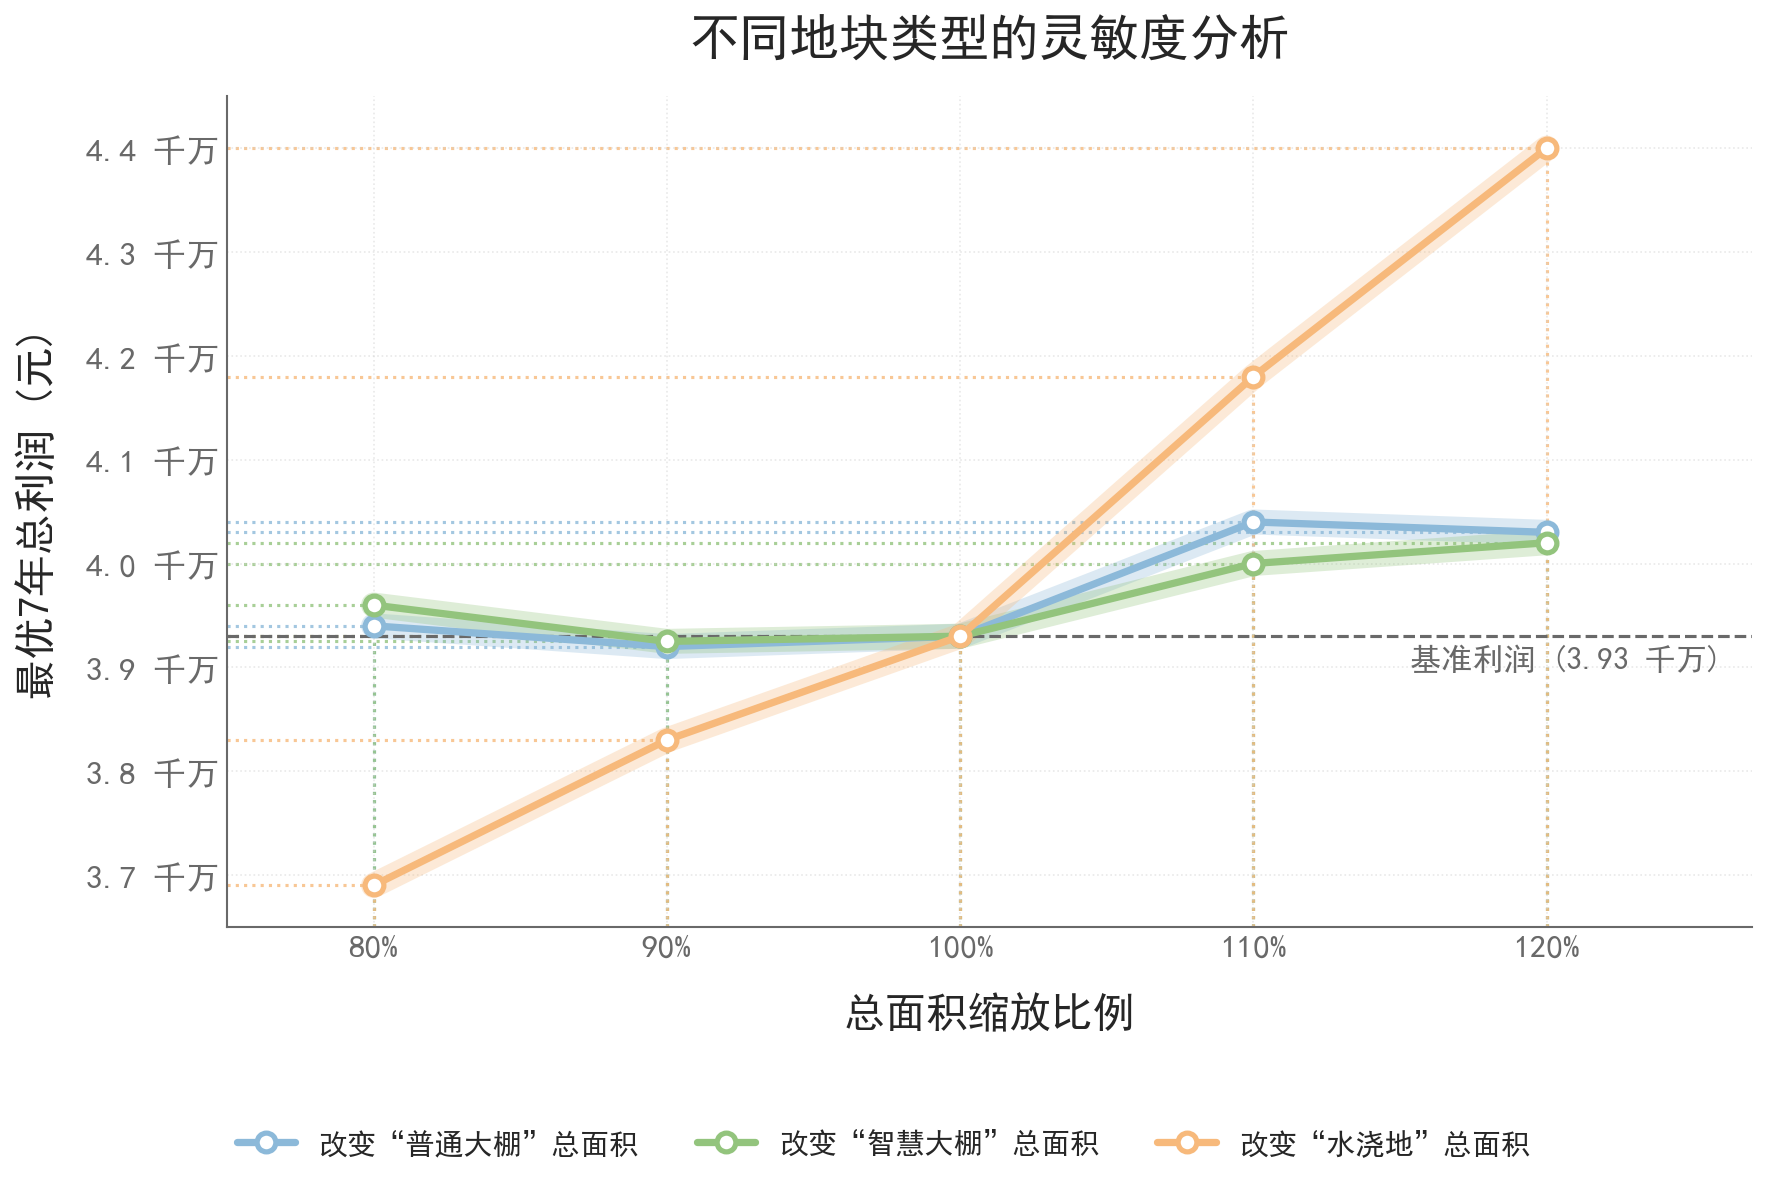

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# --- 1. 绘图风格和字体设置 ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 14

# --- 2. 数据和颜色方案 ---
x_labels = ['80%', '90%', '100%', '110%', '120%']
x_values = np.array([80, 90, 100, 110, 120])

data = {
    '改变“普通大棚”总面积': np.array([3.94, 3.92, 3.93, 4.04, 4.03]) * 1e7,
    '改变“智慧大棚”总面积': np.array([3.96, 3.925, 3.93, 4.0, 4.02]) * 1e7,
    '改变“水浇地”总面积': np.array([3.69, 3.83, 3.93, 4.18, 4.4]) * 1e7
}
baseline_profit = 3.93 * 1e7

colors = {
    '改变“普通大棚”总面积': '#8CB9D9',
    '改变“智慧大棚”总面积': '#93C47D',
    '改变“水浇地”总面积': '#F7B97B'
}
baseline_color = 'dimgray'

# --- 3. 开始绘图 ---
# 设定一个最终协调的画布尺寸
fig, ax = plt.subplots(figsize=(12, 8))

# 预先设定坐标轴范围
ax.set_xlim(75, 127)
ax.set_ylim(3.65 * 1e7, 4.45 * 1e7)

# 绘制折线图，并收集图例句柄
handles = []
labels = []
for label_full, y_values in data.items():
    color = colors.get(label_full)

    # 绘制辅助虚线
    for i in range(len(x_values)):
        ax.vlines(x=x_values[i], ymin=ax.get_ylim()[0], ymax=y_values[i],
                  color=color, linestyle=':', linewidth=1.5, alpha=0.8, zorder=0)
        ax.hlines(y=y_values[i], xmin=ax.get_xlim()[0], xmax=x_values[i],
                  color=color, linestyle=':', linewidth=1.5, alpha=0.8, zorder=0)

    # 绘制边缘阴影效果
    ax.plot(x_values, y_values, color=color, linewidth=12, alpha=0.3, zorder=1, solid_capstyle='round')
    
    # 绘制主要折线并定义空心节点样式
    line, = ax.plot(x_values, y_values, 
                    color=color, 
                    linewidth=3.5, 
                    zorder=2,
                    marker='o',
                    markerfacecolor='white',
                    markeredgecolor=color,
                    markersize=9,
                    markeredgewidth=2.5)
    # 为图例收集信息
    handles.append(line)
    labels.append(label_full)

# 绘制基准利润的虚线
ax.axhline(y=baseline_profit, color=baseline_color, linestyle='--', linewidth=1.5, zorder=1)

# --- 4. 图表样式调整 ---
ax.set_title('不同地块类型的灵敏度分析', fontsize=24, pad=20)
ax.set_xlabel('总面积缩放比例', fontsize=20, labelpad=15)
ax.set_ylabel('最优7年总利润 (元)', fontsize=20, labelpad=15)

def y_formatter(y, pos):
    return f'{y/1e7:.1f} 千万'
ax.yaxis.set_major_formatter(FuncFormatter(y_formatter))

ax.set_xticks(x_values)
ax.set_xticklabels(x_labels, fontsize=16)

# 将“基准利润”文本标注在虚线略下的位置
baseline_text = f'基准利润 ({baseline_profit/1e7:.2f} 千万)'
y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
ax.text(126, baseline_profit - y_offset, baseline_text, 
        color=baseline_color, 
        fontsize=15, 
        verticalalignment='top',
        horizontalalignment='right')

# --- 关键修复：使用 fig.legend() 来创建位于图表底部的图例 ---
fig.legend(
    handles=handles,
    labels=labels,
    loc='lower center',       # 定位在底部中央
    bbox_to_anchor=(0.5, 0), # 精确微调位置 (x, y)
    ncol=3,                   # 明确分为3列
    frameon=False, 
    fontsize=14,              # 调整字号以确保不重叠
    columnspacing=2.0         # 加大列间距
)

# 调整主网格线
ax.grid(True, which='major', linestyle=':', linewidth=0.8, color='lightgray', alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('dimgray')
ax.spines['bottom'].set_color('dimgray')

ax.tick_params(axis='x', colors='dimgray', labelsize=16)
ax.tick_params(axis='y', colors='dimgray', labelsize=16)

# 调整布局为图例留出空间
fig.tight_layout(rect=[0, 0.1, 1, 1]) # rect=[left, bottom, right, top]

# 保存图像
output_filename = "灵敏度分析图_最终修复版.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"图像已保存至: {output_filename}")

# 显示图像
plt.show()

In [10]:
# 文件名: 1_run_ga_sensitivity_analysis_75_to_125.py
# 功能: 运行遗传算法，为三种地块类型，在75%到125%的范围内生成11个数据点。

import pandas as pd
import numpy as np
import os
import re
import random
import copy
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

# --- 1. 分析与算法配置区 ---

# 【修正】根据您提供的具体11个点 (75%到125%)
AREA_SCALING_PERCENTAGES = [75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125]
# 将百分比转换为小数形式
AREA_SCALING_FACTORS = [x / 100.0 for x in AREA_SCALING_PERCENTAGES]

# 要分析的地块类型
LAND_TYPES_TO_ANALYZE = ['普通大棚', '智慧大棚', '水浇地'] 

# GA参数
POP_SIZE = 80
MAX_GEN = 150 
CX_PROB = 0.8
MUT_PROB = 0.2
TOURNAMENT_SIZE = 3
ELITISM_SIZE = 5

# --- 2. 核心功能函数 (与您提供的代码相同) ---

def load_and_prepare_data(data_path):
    # (此函数内容与您提供的完全相同，为简洁此处折叠)
    try:
        path_f1 = os.path.join(data_path, '附件1.xlsx'); path_f2 = os.path.join(data_path, '附件2.xlsx')
        plots_df = pd.read_excel(path_f1, sheet_name='乡村的现有耕地'); crops_info_df = pd.read_excel(path_f1, sheet_name='乡村种植的农作物')
        stats_df = pd.read_excel(path_f2, sheet_name='2023年统计的相关数据'); past_planting_df = pd.read_excel(path_f2, sheet_name='2023年的农作物种植情况')
    except Exception as e: print(f"错误: 读取Excel文件失败。具体错误: {e}"); return None
    for df in [plots_df, crops_info_df, stats_df, past_planting_df]: df.columns = df.columns.str.strip()
    params = {}
    params['I_plots'] = sorted(plots_df['地块名称'].tolist()); params['J_crops'] = sorted(crops_info_df['作物名称'].dropna().unique().tolist())
    params['P_area'] = dict(zip(plots_df['地块名称'], plots_df['地块面积/亩'])); params['P_plot_type'] = dict(zip(plots_df['地块名称'], plots_df['地块类型']))
    params['P_crop_type'] = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型'])); bean_keywords = ['豆', '豆类']; params['J_bean'] = [j for j, ctype in params['P_crop_type'].items() if isinstance(ctype, str) and '豆' in ctype]
    params['P_past'] = {i: {1: None, 2: None} for i in params['I_plots']}
    for _, row in past_planting_df.iterrows():
        plot, crop = row['种植地块'], row['作物名称']; season = row.get('种植季节', 1) 
        if plot in params['I_plots']: params['P_past'][plot][season] = crop
    def clean_and_convert_price(value):
        if isinstance(value, str) and any(c in value for c in '-–—'):
            parts = re.split(r'[-–—]', value.strip());
            try: return (float(parts[0]) + float(parts[1])) / 2
            except (ValueError, IndexError): return np.nan
        return pd.to_numeric(value, errors='coerce')
    stats_df['销售单价/(元/斤)'] = stats_df['销售单价/(元/斤)'].apply(clean_and_convert_price); stats_df['亩产量/斤'] = pd.to_numeric(stats_df['亩产量/斤'], errors='coerce'); stats_df['种植成本/(元/亩)'] = pd.to_numeric(stats_df['种植成本/(元/亩)'], errors='coerce')
    stats_df.dropna(subset=['亩产量/斤', '种植成本/(元/亩)', '销售单价/(元/斤)'], inplace=True)
    params['P_yield'], params['P_cost'], params['P_price'] = {}, {}, {}
    for _, row in stats_df.iterrows():
        key = (row['作物名称'], row['地块类型']); params['P_cost'][key] = row['种植成本/(元/亩)']; params['P_yield'][key] = row['亩产量/斤']; params['P_price'][key] = row['销售单价/(元/斤)']
    for crop in params['J_crops']:
        for plot_type in plots_df['地块类型'].unique():
            key = (crop, plot_type)
            if key not in params['P_yield']: params['P_yield'][key], params['P_cost'][key], params['P_price'][key] = 0, 9e9, 0
    params['P_demand'] = {j: 0 for j in params['J_crops']}
    temp_details = pd.merge(past_planting_df, plots_df, left_on='种植地块', right_on='地块名称')
    for j in params['J_crops']:
        total_yield = sum(params['P_yield'].get((j, row['地块类型']), 0) * row.get('种植面积/亩', params['P_area'][row['地块名称']]) for _, row in temp_details[temp_details['作物名称'] == j].iterrows())
        params['P_demand'][j] = total_yield if total_yield > 0 else 1000
    params['S_suitability'] = {}; restricted_veg = ['大白菜', '白萝卜', '红萝卜']
    for i in params['I_plots']:
        plot_t = params['P_plot_type'].get(i, '')
        for j in params['J_crops']:
            crop_t = params['P_crop_type'].get(j, ''); is_veg = '蔬菜' in str(crop_t)
            for k in [1, 2]:
                suitable = 0
                if plot_t in ['平旱地', '梯田', '山坡地'] and ('粮食' in str(crop_t) or j in params['J_bean']) and k == 1: suitable = 1
                elif plot_t == '水浇地':
                    if '水稻' in j:
                        if k == 1: suitable = 1
                    elif is_veg:
                        if j not in restricted_veg and k == 1: suitable = 1
                        elif j in restricted_veg and k == 2: suitable = 1
                elif plot_t == '普通大棚':
                    if is_veg and j not in restricted_veg and k == 1: suitable = 1
                    elif '食用菌' in str(crop_t) and k == 2: suitable = 1
                elif plot_t == '智慧大棚' and is_veg and j not in restricted_veg: suitable = 1
                params['S_suitability'][(i, j, k)] = suitable
    print(" -> 数据参数准备完成。")
    return params

def crossover(parent1, parent2, params):
    child = copy.deepcopy(parent1)
    years = list(parent1.keys())
    k_seasons = [1, 2]
    y_point = random.choice(years)
    k_point = random.choice(k_seasons)
    for y in years:
        for k in k_seasons:
            if (y > y_point) or (y == y_point and k >= k_point):
                for i in params['I_plots']:
                    child[y][k][i] = parent2[y][k][i]
    return child

def mutate(solution, params):
    years = list(solution.keys())
    k_seasons = [1, 2]
    y = random.choice(years)
    k = random.choice(k_seasons)
    i = random.choice(params['I_plots'])
    possible_crops = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1 and params['P_cost'].get((j, params['P_plot_type'][i]), 9e9) < 1e9]
    if possible_crops:
        solution[y][k][i] = random.choice(possible_crops)
    return solution

class GeneticAlgorithm:
    # (整个类的代码与您提供的完全相同，为简洁此处折叠)
    def __init__(self, params, scenario):
        self.params = params; self.scenario = scenario; self.years = list(range(2024, 2031))
    def create_initial_solution(self):
        solution = {y: {k: {i: None for i in self.params['I_plots']} for k in [1, 2]} for y in self.years}
        for y in self.years:
            for i in self.params['I_plots']:
                for k in [1, 2]:
                    possible_crops = [j for j in self.params['J_crops'] if self.params['S_suitability'].get((i, j, k), 0) == 1 and self.params['P_cost'].get((j, self.params['P_plot_type'][i]), 9e9) < 1e9]
                    if possible_crops: solution[y][k][i] = random.choice(possible_crops)
        return self.repair_solution(solution)
    def repair_solution(self, solution):
        def get_crops_in_year(sol, y, i):
            crops = set()
            if y == 2023:
                for k in [1, 2]:
                    crop = self.params['P_past'].get(i, {}).get(k)
                    if crop: crops.add(crop)
            elif y in sol:
                for k in [1, 2]:
                    crop = sol.get(y, {}).get(k, {}).get(i)
                    if crop: crops.add(crop)
            return list(crops)
        for i in self.params['I_plots']:
            for y in self.years:
                crops_this_year = get_crops_in_year(solution, y, i); crops_last_year = get_crops_in_year(solution, y - 1, i)
                common_crops = set(crops_this_year) & set(crops_last_year)
                if common_crops:
                    for k in [1, 2]:
                        if solution[y][k][i] in common_crops:
                            possible_replacements = [j for j in self.params['J_crops'] if self.params['S_suitability'].get((i, j, k), 0) == 1 and self.params['P_cost'].get((j, self.params['P_plot_type'][i]), 9e9) < 1e9 and j not in crops_last_year]
                            solution[y][k][i] = random.choice(possible_replacements) if possible_replacements else None
        for i in self.params['I_plots']:
            if self.params['P_plot_type'].get(i) not in ['平旱地', '梯田', '山坡地', '水浇地']: continue
            all_years_sorted = [2023] + self.years
            for y_start_idx in range(len(all_years_sorted) - 2):
                window = all_years_sorted[y_start_idx : y_start_idx + 3]
                contains_bean = any(c in self.params['J_bean'] for y_win in window for c in get_crops_in_year(solution, y_win, i))
                if not contains_bean:
                    for _ in range(5):
                        y_fix = random.choice([y for y in window if y > 2023]); k_fix = 1
                        crops_last_year_for_fix = get_crops_in_year(solution, y_fix - 1, i)
                        possible_beans = [b for b in self.params['J_bean'] if self.params['S_suitability'].get((i, b, k_fix), 0) == 1 and self.params['P_cost'].get((b, self.params['P_plot_type'][i]), 9e9) < 1e9 and b not in crops_last_year_for_fix]
                        if possible_beans: solution[y_fix][k_fix][i] = random.choice(possible_beans); break
        return solution
    def evaluate_fitness(self, solution):
        total_revenue, total_cost = 0, 0; total_production = defaultdict(float)
        for y in self.years:
            for i in self.params['I_plots']:
                plot_type = self.params['P_plot_type'][i]; area = self.params['P_area'][i]
                for k in [1, 2]:
                    crop = solution[y][k][i]
                    if not crop: continue
                    key = (crop, plot_type); cost = self.params['P_cost'].get(key, 0); yield_val = self.params['P_yield'].get(key, 0)
                    total_cost += area * cost; total_production[crop] += area * yield_val
        for crop, production in total_production.items():
            total_demand = self.params['P_demand'].get(crop, 0) * 7
            price = next((p for (c, pt), p in self.params['P_price'].items() if c == crop), 0)
            if self.scenario == 'waste': sold_qty = min(production, total_demand); total_revenue += sold_qty * price
            elif self.scenario == 'discount': normal_qty = min(production, total_demand); over_qty = production - normal_qty; total_revenue += (normal_qty * price) + (over_qty * price * 0.5)
        return total_revenue - total_cost
    def run(self):
        population = [self.create_initial_solution() for _ in range(POP_SIZE)]; best_fitness = -np.inf
        pbar = tqdm(range(MAX_GEN), leave=False)
        for gen in pbar:
            fitnesses = [self.evaluate_fitness(sol) for sol in population]; best_fit_gen = np.max(fitnesses)
            if best_fit_gen > best_fitness: best_fitness = best_fit_gen
            pbar.set_description(f"当前最优利润: {best_fitness:,.0f}")
            elite_indices = np.argsort(fitnesses)[-ELITISM_SIZE:]; new_population = [population[i] for i in elite_indices]
            while len(new_population) < POP_SIZE:
                def tournament_selection(pop, fits, k):
                    best_idx = random.randrange(len(pop));
                    for _ in range(k-1): idx=random.randrange(len(pop)); best_idx = idx if fits[idx]>fits[best_idx] else best_idx
                    return pop[best_idx]
                p1 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE); p2 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
                child = crossover(p1, p2, self.params) if random.random() < CX_PROB else copy.deepcopy(p1)
                if random.random() < MUT_PROB: child = mutate(child, self.params)
                new_population.append(self.repair_solution(child))
            population = new_population
        return best_fitness

# --- 3. 主程序 ---
if __name__ == '__main__':
    try:
        current_dir = Path.cwd()
        data_path = current_dir / '..' / 'Data'
        output_dir = current_dir / '..' / '改图'
        output_dir.mkdir(parents=True, exist_ok=True)
        # 【修改】更新输出文件名以反映新的范围
        results_output_path = output_dir / 'area_sensitivity_analysis_results_75_to_125.csv'

        base_params = load_and_prepare_data(data_path)
        if not base_params: raise RuntimeError("数据加载失败。")

        print("\n" + "="*50 + "\n正在对土地面积进行灵敏度分析 (每种类型11个点, 75%-125%)...\n" + "="*50)
        
        all_results = []
        
        for land_type in LAND_TYPES_TO_ANALYZE:
            for scale in tqdm(AREA_SCALING_FACTORS, desc=f"分析地块类型: {land_type}"):
                
                temp_params = copy.deepcopy(base_params)
                
                for plot_name, original_area in temp_params['P_area'].items():
                    if temp_params['P_plot_type'][plot_name] == land_type:
                        temp_params['P_area'][plot_name] = original_area * scale
                
                ga_solver = GeneticAlgorithm(temp_params, 'discount')
                best_profit = ga_solver.run()

                all_results.append({
                    '场景': land_type,
                    '面积缩放比例(%)': int(round(scale * 100)),
                    '最优总利润(元)': best_profit
                })
                print(f"-> {land_type} @ {scale*100:.0f}%: 利润 = {best_profit:,.2f} 元")

        results_df = pd.DataFrame(all_results)
        results_df.to_csv(results_output_path, index=False, encoding='utf-8-sig')
        
        print("\n" + "="*50)
        print("所有分析任务完成！")
        print(f"详细数据已保存至: {results_output_path.resolve()}")
        print("="*50)

    except Exception as e:
        print(f"\n程序主流程发生错误: {e}")
        import traceback
        traceback.print_exc()

 -> 数据参数准备完成。

正在对土地面积进行灵敏度分析 (每种类型11个点, 75%-125%)...


分析地块类型: 普通大棚:   9%|▉         | 1/11 [00:25<04:18, 25.81s/it]

-> 普通大棚 @ 75%: 利润 = 39,382,601.50 元


分析地块类型: 普通大棚:  18%|█▊        | 2/11 [00:52<03:56, 26.27s/it]

-> 普通大棚 @ 80%: 利润 = 40,667,231.38 元


分析地块类型: 普通大棚:  27%|██▋       | 3/11 [01:14<03:16, 24.55s/it]

-> 普通大棚 @ 85%: 利润 = 40,111,971.12 元


分析地块类型: 普通大棚:  36%|███▋      | 4/11 [01:38<02:49, 24.17s/it]

-> 普通大棚 @ 90%: 利润 = 39,737,203.12 元


分析地块类型: 普通大棚:  45%|████▌     | 5/11 [02:02<02:24, 24.13s/it]

-> 普通大棚 @ 95%: 利润 = 39,774,799.12 元


分析地块类型: 普通大棚:  55%|█████▍    | 6/11 [02:26<01:59, 23.94s/it]

-> 普通大棚 @ 100%: 利润 = 38,467,449.50 元


分析地块类型: 普通大棚:  64%|██████▎   | 7/11 [02:49<01:35, 23.84s/it]

-> 普通大棚 @ 105%: 利润 = 41,142,230.50 元


分析地块类型: 普通大棚:  73%|███████▎  | 8/11 [03:12<01:10, 23.52s/it]

-> 普通大棚 @ 110%: 利润 = 40,655,340.38 元


分析地块类型: 普通大棚:  82%|████████▏ | 9/11 [03:39<00:49, 24.70s/it]

-> 普通大棚 @ 115%: 利润 = 38,701,480.75 元


分析地块类型: 普通大棚:  91%|█████████ | 10/11 [04:02<00:24, 24.08s/it]

-> 普通大棚 @ 120%: 利润 = 40,544,111.00 元


分析地块类型: 普通大棚: 100%|██████████| 11/11 [04:23<00:00, 23.99s/it]


-> 普通大棚 @ 125%: 利润 = 40,162,856.38 元


分析地块类型: 智慧大棚:   9%|▉         | 1/11 [00:22<03:42, 22.24s/it]

-> 智慧大棚 @ 75%: 利润 = 39,273,063.00 元


分析地块类型: 智慧大棚:  18%|█▊        | 2/11 [00:43<03:15, 21.75s/it]

-> 智慧大棚 @ 80%: 利润 = 38,654,345.58 元


分析地块类型: 智慧大棚:  27%|██▋       | 3/11 [01:06<02:58, 22.32s/it]

-> 智慧大棚 @ 85%: 利润 = 39,738,051.62 元


分析地块类型: 智慧大棚:  36%|███▋      | 4/11 [01:33<02:48, 24.10s/it]

-> 智慧大棚 @ 90%: 利润 = 39,042,812.35 元


分析地块类型: 智慧大棚:  45%|████▌     | 5/11 [01:57<02:25, 24.21s/it]

-> 智慧大棚 @ 95%: 利润 = 39,884,493.80 元


分析地块类型: 智慧大棚:  55%|█████▍    | 6/11 [02:20<01:57, 23.51s/it]

-> 智慧大棚 @ 100%: 利润 = 40,200,736.75 元


分析地块类型: 智慧大棚:  64%|██████▎   | 7/11 [02:42<01:32, 23.11s/it]

-> 智慧大棚 @ 105%: 利润 = 40,220,896.75 元


分析地块类型: 智慧大棚:  73%|███████▎  | 8/11 [03:03<01:07, 22.59s/it]

-> 智慧大棚 @ 110%: 利润 = 38,834,516.10 元


分析地块类型: 智慧大棚:  82%|████████▏ | 9/11 [03:28<00:46, 23.24s/it]

-> 智慧大棚 @ 115%: 利润 = 40,088,216.93 元


分析地块类型: 智慧大棚:  91%|█████████ | 10/11 [03:50<00:22, 22.89s/it]

-> 智慧大棚 @ 120%: 利润 = 40,024,754.70 元


分析地块类型: 智慧大棚: 100%|██████████| 11/11 [04:14<00:00, 23.16s/it]


-> 智慧大棚 @ 125%: 利润 = 38,724,589.38 元


分析地块类型: 水浇地:   9%|▉         | 1/11 [00:23<03:58, 23.83s/it]

-> 水浇地 @ 75%: 利润 = 34,279,438.62 元


分析地块类型: 水浇地:  18%|█▊        | 2/11 [00:49<03:44, 24.90s/it]

-> 水浇地 @ 80%: 利润 = 35,937,701.88 元


分析地块类型: 水浇地:  27%|██▋       | 3/11 [01:14<03:18, 24.77s/it]

-> 水浇地 @ 85%: 利润 = 36,379,995.62 元


分析地块类型: 水浇地:  36%|███▋      | 4/11 [01:40<02:58, 25.46s/it]

-> 水浇地 @ 90%: 利润 = 38,500,015.12 元


分析地块类型: 水浇地:  45%|████▌     | 5/11 [02:05<02:31, 25.23s/it]

-> 水浇地 @ 95%: 利润 = 38,899,330.50 元


分析地块类型: 水浇地:  55%|█████▍    | 6/11 [02:29<02:03, 24.68s/it]

-> 水浇地 @ 100%: 利润 = 40,072,677.88 元


分析地块类型: 水浇地:  64%|██████▎   | 7/11 [02:55<01:40, 25.24s/it]

-> 水浇地 @ 105%: 利润 = 40,263,622.62 元


分析地块类型: 水浇地:  73%|███████▎  | 8/11 [03:20<01:15, 25.19s/it]

-> 水浇地 @ 110%: 利润 = 42,212,416.50 元


分析地块类型: 水浇地:  82%|████████▏ | 9/11 [03:45<00:50, 25.01s/it]

-> 水浇地 @ 115%: 利润 = 41,550,791.12 元


分析地块类型: 水浇地:  91%|█████████ | 10/11 [04:08<00:24, 24.39s/it]

-> 水浇地 @ 120%: 利润 = 43,876,081.12 元


分析地块类型: 水浇地: 100%|██████████| 11/11 [04:29<00:00, 24.55s/it]

-> 水浇地 @ 125%: 利润 = 43,764,569.38 元

所有分析任务完成！
详细数据已保存至: C:\Users\86185\Desktop\2024C\改图\area_sensitivity_analysis_results_75_to_125.csv


In [ ]:
# 文件名: 7_visualize_final_compact_layout_debugged.py
# 功能: 增加了plt.close('all')来尝试解决缓存问题。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from pathlib import Path

# --- 1. 用户偏好与绘图风格设置 ---
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150

FIG_TITLE_FONT_SIZE = 30
SUBPLOT_TITLE_FONT_SIZE = 24
LABEL_FONT_SIZE = 15
CBAR_TITLE_FONT_SIZE = 16

# --- 2. 读取数据 ---
try:
    results_df = pd.read_csv(Path("../改图/area_sensitivity_analysis_results_75_to_125.csv"))
except FileNotFoundError:
    print("错误：找不到 'area_sensitivity_analysis_results_75_to_125.csv' 文件。")
    print("请先运行第一个“训练代码”来生成数据文件。")
    exit()

# --- 3. 数据处理 ---
try:
    baseline_profit = results_df[results_df['面积缩放比例(%)'] == 100]['最优总利润(元)'].mean()
    if pd.isna(baseline_profit): raise ValueError
except (ValueError, IndexError):
    print("错误：无法在结果中找到100%基准点用于计算变化率。")
    exit()

results_df['利润变化率(%)'] = ((results_df['最优总利润(元)'] / baseline_profit) - 1) * 100
results_df_plot = results_df[results_df['面积缩放比例(%)'] != 100].copy()

# --- 4. 核心绘图模块 ---
def draw_custom_donut_chart(ax, data_df, title, cmap, area_norm):
    df_sorted = data_df.sort_values(by='利润变化率(%)', ascending=False).reset_index(drop=True)
    
    profit_values = df_sorted['利润变化率(%)']
    area_values = df_sorted['面积缩放比例(%)']
    n_bars = len(df_sorted)
    
    thetas = np.linspace(0, 2 * np.pi, n_bars, endpoint=False)
    width = 2 * np.pi / n_bars * 0.85
    
    # 您可以在这里自由调整这个值
    bottom_radius = 2
    
    colors = cmap(area_norm(area_values))
    
    bars = ax.bar(thetas, profit_values, width=width, bottom=bottom_radius, 
                  color=colors, alpha=0.9, edgecolor='white', linewidth=0.5)
    
    offset = (profit_values.max() - profit_values.min()) * 0.08 
    
    for bar, theta, value in zip(bars, thetas, profit_values):
        label_radius = bottom_radius + value
        vertical_alignment = 'bottom' if value >= 0 else 'top'
        label_radius += offset if value >= 0 else -offset
        
        rotation = np.rad2deg(theta)
        if 90 < rotation < 270: rotation += 180
            
        ax.text(theta, label_radius, f'{value:.1f}%',
                ha='center', va=vertical_alignment, fontsize=LABEL_FONT_SIZE,
                rotation=rotation, rotation_mode='anchor')
    
    ax.set_title(title, fontsize=SUBPLOT_TITLE_FONT_SIZE, pad=25)
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    
    ax.set_ylim(bottom_radius + min(0, profit_values.min()) - offset*3, 
                bottom_radius + profit_values.max() + offset*3)

# --- 5. 主程序：创建并排列三张图 ---
# 【解决方案】在创建新图前，关闭所有旧的图窗
plt.close('all')

fig = plt.figure(figsize=(28, 11))
fig.suptitle('不同地块类型面积变化的利润影响分析', fontsize=FIG_TITLE_FONT_SIZE, weight='bold')

ax_positions = [
    [0.02, 0.25, 0.33, 0.6],
    [0.30, 0.25, 0.33, 0.6],
    [0.58, 0.25, 0.33, 0.6]
]
axes = [fig.add_axes(pos, projection='polar') for pos in ax_positions]

scenarios_to_plot = ['普通大棚', '智慧大棚', '水浇地']
color_maps = {'普通大棚': plt.cm.Blues, '智慧大棚': plt.cm.Greens, '水浇地': plt.cm.Oranges}

area_min = results_df_plot['面积缩放比例(%)'].min()
area_max = results_df_plot['面积缩放比例(%)'].max()
area_norm_global = mcolors.Normalize(vmin=area_min, vmax=area_max)

for i, scenario in enumerate(scenarios_to_plot):
    ax = axes[i]
    data_subset = results_df_plot[results_df_plot['场景'] == scenario]
    cmap = color_maps[scenario]
    draw_custom_donut_chart(ax, data_subset, f'改变“{scenario}”总面积', cmap, area_norm_global)
    
    pos = ax.get_position()
    cbar_width = pos.width * 0.7
    cbar_left = pos.x0 + (pos.width - cbar_width) / 2
    cbar_ax = fig.add_axes([cbar_left, pos.y0 + 0.05, cbar_width, 0.03])
    
    sm = ScalarMappable(cmap=cmap, norm=area_norm_global)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('面积变化率 (%)', size=CBAR_TITLE_FONT_SIZE, labelpad=10)
    cbar.ax.tick_params(labelsize=12)

# --- 6. 保存与显示 ---
output_filename = "三种地块灵敏度圆弧图_最终版.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"图像已保存至: {output_filename}")
plt.show()

正在加载数据...


C:\Users\86185\AppData\Local\Temp\ipykernel_37456\224384101.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sort_df['类型'].fillna('其他', inplace=True)
C:\Users\86185\AppData\Local\Temp\ipykernel_37456\224384101.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  original_cmap = cm.get_cmap('YlGn')


横轴作物排序完成。
筛选并处理2024年数据...
开始绘制最终版热力图...


C:\Users\86185\AppData\Local\Temp\ipykernel_37456\224384101.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])



图表已成功保存至: Result\2024年最优种植方案（最终版）.png


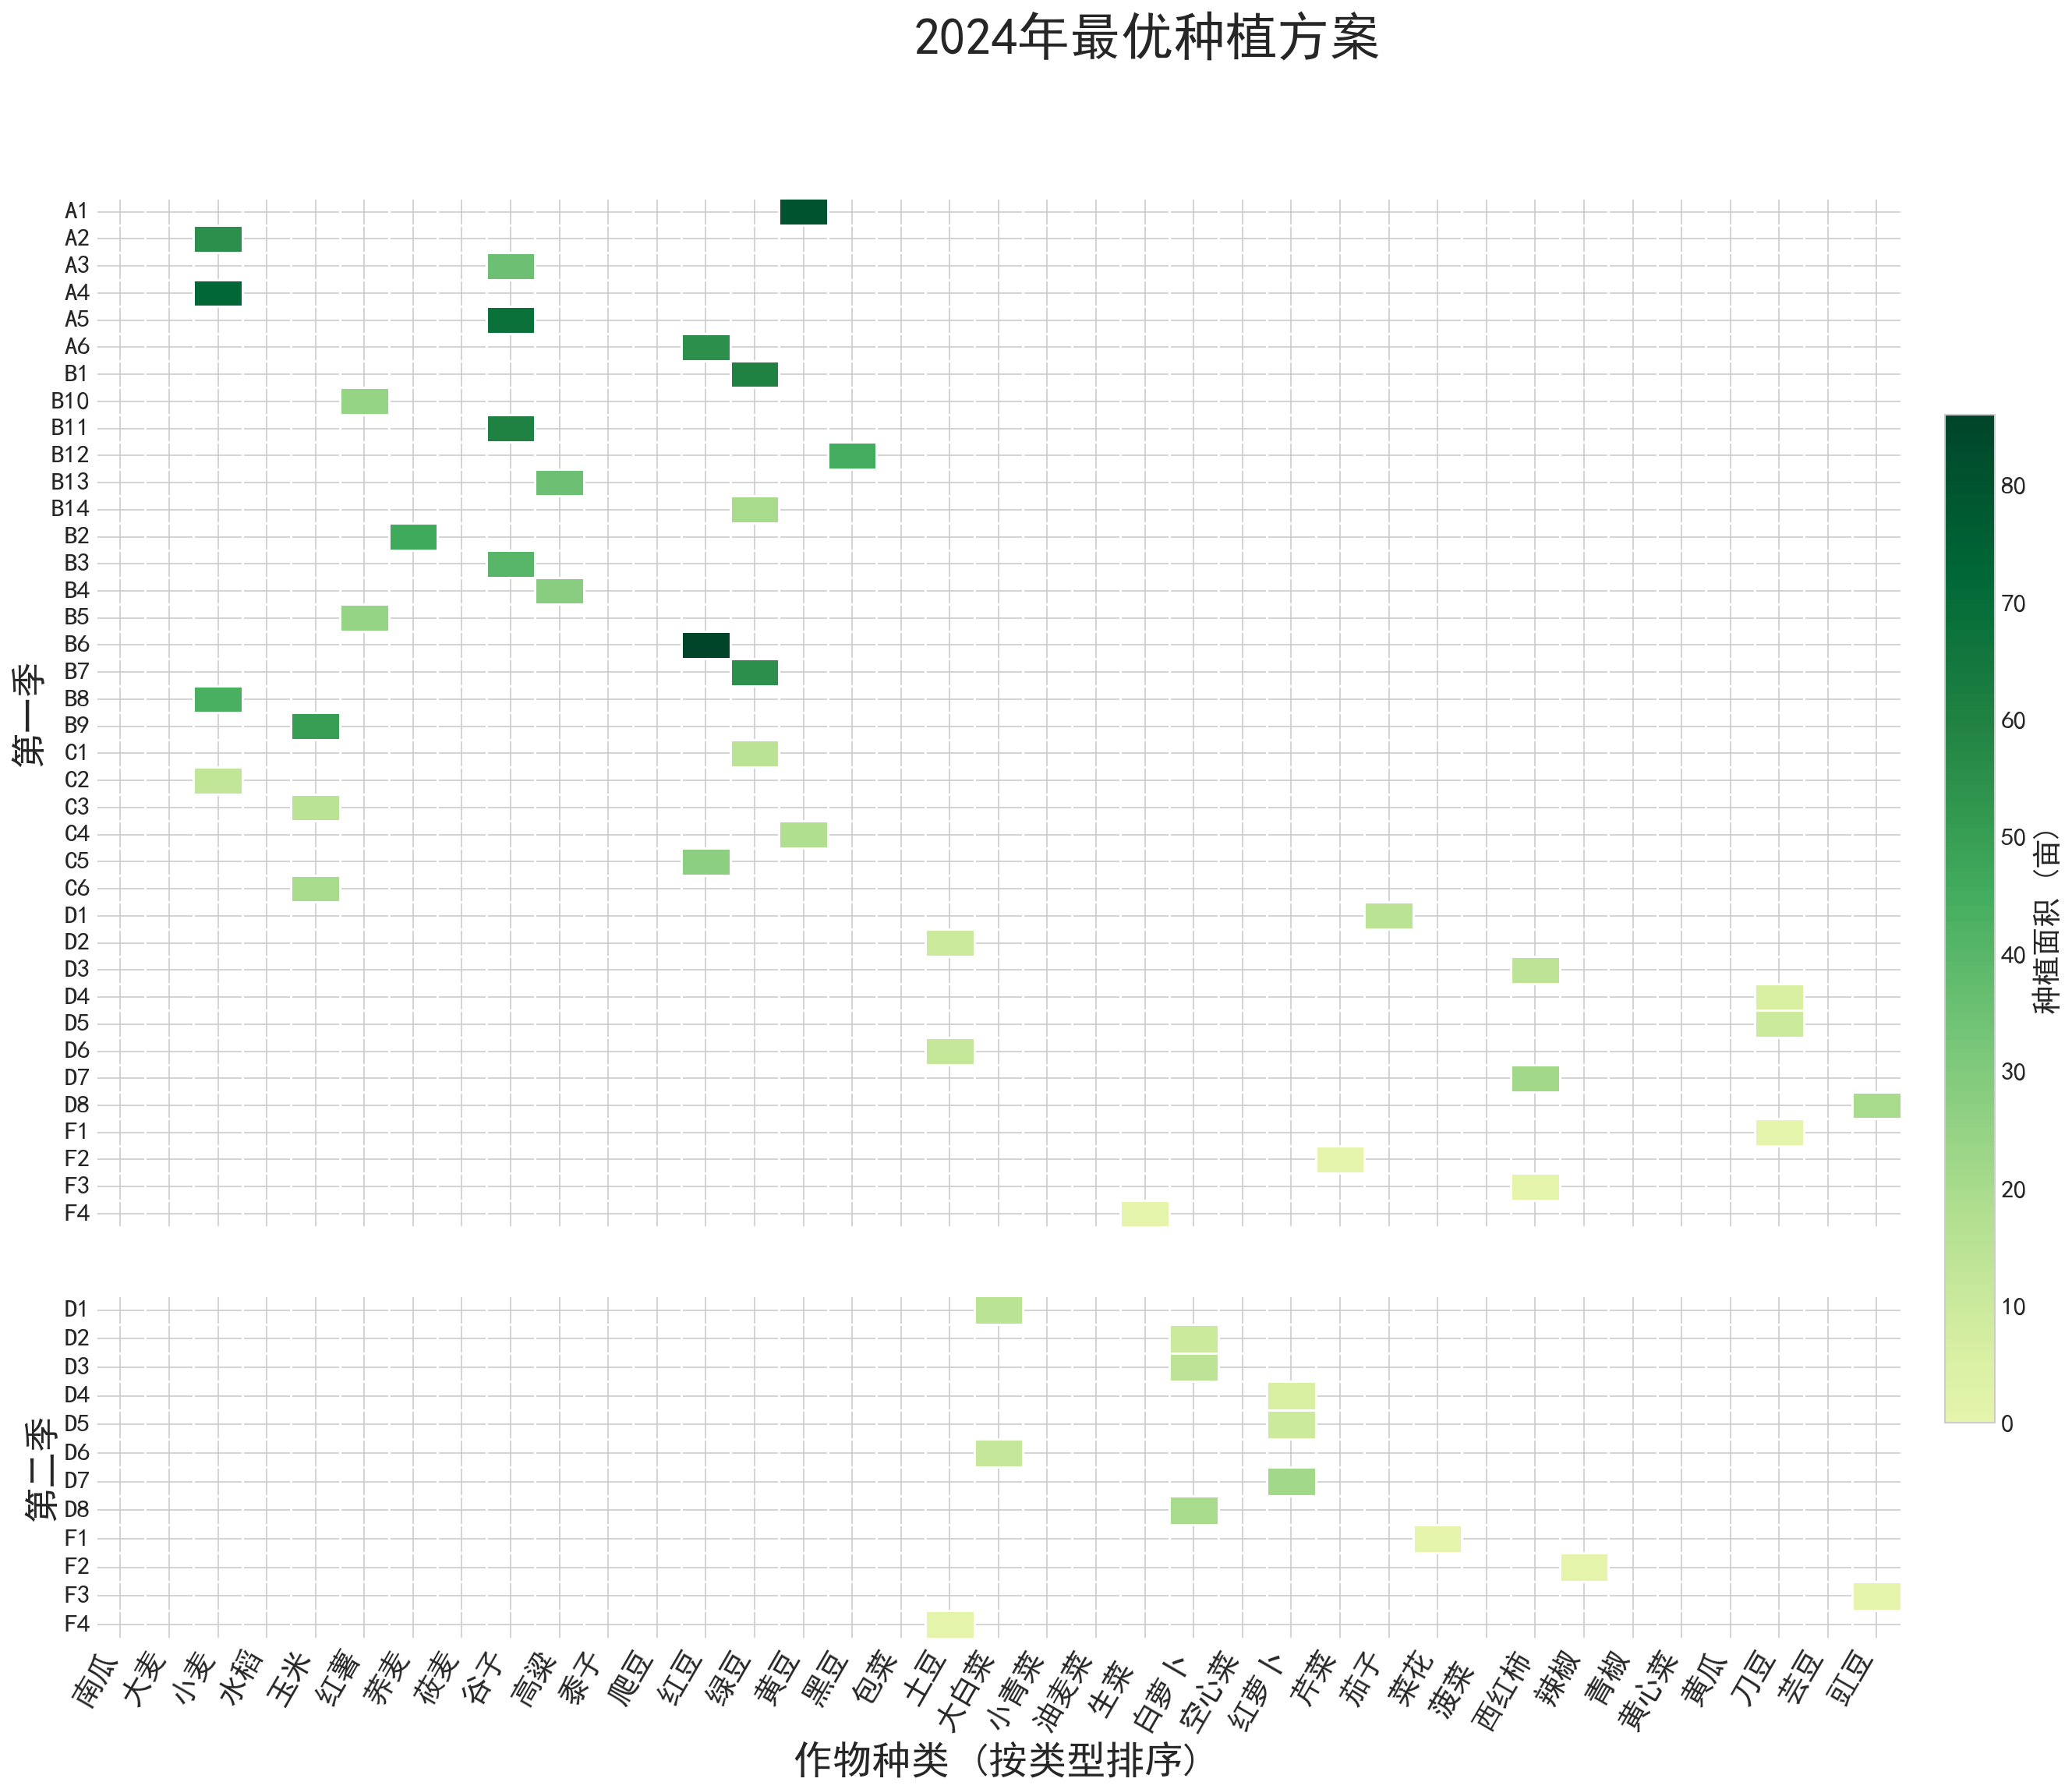

In [ ]:
# -*- coding: utf-8 -*-
# 文件名: plot_discrete_heatmap_final_polished_v3.py
# 功能: 修正中间出现X轴标签的布局问题。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

# --- 1. 绘图与文件路径配置 ---

# 设置绘图风格以符合学术审美
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150

# 定义大字号
SUPTITLE_FONT_SIZE = 32
LABEL_FONT_SIZE = 24
YLABEL_FONT_SIZE = 22
CBAR_LABEL_FONT_SIZE = 18
XTICK_FONT_SIZE = 18
YTICK_FONT_SIZE = 16


# --- 文件路径定义 ---
INPUT_RESULT_XLSX = Path('./Result/result1_1.xlsx')
INPUT_ATTACHMENT_XLSX = Path('../Data/附件1.xlsx')
OUTPUT_IMAGE_PATH = Path('./Result/2024年最优种植方案（情况一）.png')


# --- 2. 数据加载与核心解析 ---

try:
    print("正在加载数据...")
    full_df = pd.read_excel(INPUT_RESULT_XLSX)
    crop_types_df = pd.read_excel(INPUT_ATTACHMENT_XLSX, sheet_name='乡村种植的农作物')

    # --- 根据作物类型进行智能排序 ---
    crop_to_type_map = dict(zip(crop_types_df['作物名称'], crop_types_df['作物类型']))
    all_crops_in_data = sorted(full_df['作物名称'].unique())
    sort_df = pd.DataFrame({'作物': all_crops_in_data})
    sort_df['类型'] = sort_df['作物'].map(crop_to_type_map)
    sort_df['类型'].fillna('其他', inplace=True)
    sort_df.sort_values(by=['类型', '作物'], inplace=True)
    all_crops_master_list = sort_df['作物'].tolist()
    print("横轴作物排序完成。")

    # --- 数据筛选与准备 ---
    print("筛选并处理2024年数据...")
    df = full_df[full_df['年份'] == 2024].copy()
    
    if df.empty:
        print("错误：在文件中没有找到年份为 2024 的数据记录。")
    else:
        df.rename(columns={'地块编号': '地块', '作物名称': '作物', '种植面积（亩）': '面积'}, inplace=True)
        season_map = {1: '第一季', 2: '第二季'}
        df['季节'] = df['季节'].map(season_map)
        df = df[df['面积'] > 0.01].copy()
        
        # --- 3. 为绘图准备数据 (数据透视) ---
        df_s1 = df[df['季节'] == '第一季'].copy()
        df_s2 = df[df['季节'] == '第二季'].copy()
        pivot_s1 = df_s1.pivot_table(index='地块', columns='作物', values='面积') if not df_s1.empty else pd.DataFrame()
        pivot_s2 = df_s2.pivot_table(index='地块', columns='作物', values='面积') if not df_s2.empty else pd.DataFrame()
        
        plots_s1 = sorted(df_s1['地块'].unique())
        plots_s2 = sorted(df_s2['地块'].unique())
        
        pivot_s1 = pivot_s1.reindex(index=plots_s1, columns=all_crops_master_list)
        pivot_s2 = pivot_s2.reindex(index=plots_s2, columns=all_crops_master_list)
        
        v_max_global = df['面积'].max()

        # --- 4. 核心绘图模块 ---
        
        # 创建统一的、照顾低数值的纯绿色系
        original_cmap = cm.get_cmap('YlGn')
        new_colors = original_cmap(np.linspace(0.2, 1, 256))
        custom_unified_cmap = LinearSegmentedColormap.from_list("custom_unified_green", new_colors)
        
        print("开始绘制最终版热力图...")
        
        fig = plt.figure(figsize=(24, 16))
        height_ratios = [len(plots_s1) + 1, len(plots_s2) + 1]
        gs = GridSpec(nrows=2, ncols=1, height_ratios=height_ratios, hspace=0.1)
        
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        
        # --- 【核心修改】彻底隐藏上图的X轴所有元素 ---
        plt.setp(ax1.get_xticklabels(), visible=False)
        ax1.tick_params(axis='x', length=0)
        ax1.xaxis.label.set_visible(False)

        # 绘制第一季 (不绘制颜色条)
        sns.heatmap(pivot_s1, ax=ax1, cmap=custom_unified_cmap,
                    linewidths=0.5, linecolor='white',
                    cbar=False, vmin=0, vmax=v_max_global)
        ax1.set_ylabel('第一季', fontsize=YLABEL_FONT_SIZE, weight='bold')

        # 绘制第二季 (不绘制颜色条)
        sns.heatmap(pivot_s2, ax=ax2, cmap=custom_unified_cmap,
                    linewidths=0.5, linecolor='white',
                    cbar=False, vmin=0, vmax=v_max_global)
        ax2.set_ylabel('第二季', fontsize=YLABEL_FONT_SIZE, weight='bold')
        ax2.set_xlabel('作物种类 (按类型排序)', fontsize=LABEL_FONT_SIZE)
        
        # 使用更智能的方式创建单一、居中的颜色条
        mappable = ax1.collections[0]
        cbar = fig.colorbar(mappable, ax=[ax1, ax2], shrink=0.7, pad=0.02)
        cbar.set_label('种植面积 (亩)', size=CBAR_LABEL_FONT_SIZE)
        cbar.ax.tick_params(labelsize=YTICK_FONT_SIZE)

        # 字体与其他排版微调
        plt.xticks(rotation=60, ha='right', fontsize=XTICK_FONT_SIZE)
        ax1.tick_params(axis='y', labelsize=YTICK_FONT_SIZE, rotation=0)
        ax2.tick_params(axis='y', labelsize=YTICK_FONT_SIZE, rotation=0)

        fig.suptitle('2024年最优种植（情况一）', fontsize=SUPTITLE_FONT_SIZE, weight='bold')
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # --- 5. 保存与显示 ---
        OUTPUT_IMAGE_PATH.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(OUTPUT_IMAGE_PATH, dpi=300, bbox_inches='tight')
        print(f"\n图表已成功保存至: {OUTPUT_IMAGE_PATH}")
        
        plt.show()

except FileNotFoundError as e:
    print(f"错误：无法找到数据文件。请检查您的文件路径是否正确。")
    print(f"1. 结果文件应在: {INPUT_RESULT_XLSX.resolve()}")
    print(f"2. 附件文件应在: {INPUT_ATTACHMENT_XLSX.resolve()}")
except KeyError as e:
    print(f"错误：文件中似乎缺少必需的列: {e}。")
except Exception as e:
    print(f"程序发生未知错误: {e}")
    import traceback
    traceback.print_exc()

In [1]:
# 文件名: 1_run_q1_sensitivity_analysis.py
# 功能: 实现问题一的完整灵敏度分析，包括单因素扰动和多因素情景分析。

import pandas as pd
import numpy as np
import os
import re
import random
import copy
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

# --- 1. 分析与算法配置区 ---

# === 第1部分：单因素扰动分析配置 ===
# 选择要分析的关键作物 (您可以根据实际情况增删)
CROPS_TO_ANALYZE = ['黄瓜', '玉米', '羊肚菌'] 
# 定义扰动范围 (例如, 80% 到 120%)
PERTURBATION_FACTORS = [0.8, 0.9, 1.0, 1.1, 1.2] 

# === 第2部分：多因素情景分析配置 ===
# (此处无需配置，情景在主程序中直接定义)

# GA参数 (保持不变)
POP_SIZE = 80
MAX_GEN = 150 
CX_PROB = 0.8
MUT_PROB = 0.2
TOURNAMENT_SIZE = 3
ELITISM_SIZE = 5

# --- 2. 核心功能函数 (基本与您提供的代码相同) ---

def load_and_prepare_data(data_path):
    # (此函数内容与您提供的完全相同，为简洁此处折叠)
    try:
        path_f1 = os.path.join(data_path, '附件1.xlsx'); path_f2 = os.path.join(data_path, '附件2.xlsx')
        plots_df = pd.read_excel(path_f1, sheet_name='乡村的现有耕地'); crops_info_df = pd.read_excel(path_f1, sheet_name='乡村种植的农作物')
        stats_df = pd.read_excel(path_f2, sheet_name='2023年统计的相关数据'); past_planting_df = pd.read_excel(path_f2, sheet_name='2023年的农作物种植情况')
    except Exception as e: print(f"错误: 读取Excel文件失败。具体错误: {e}"); return None
    for df in [plots_df, crops_info_df, stats_df, past_planting_df]: df.columns = df.columns.str.strip()
    params = {}
    params['I_plots'] = sorted(plots_df['地块名称'].tolist()); params['J_crops'] = sorted(crops_info_df['作物名称'].dropna().unique().tolist())
    params['P_area'] = dict(zip(plots_df['地块名称'], plots_df['地块面积/亩'])); params['P_plot_type'] = dict(zip(plots_df['地块名称'], plots_df['地块类型']))
    params['P_crop_type'] = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型'])); bean_keywords = ['豆', '豆类']; params['J_bean'] = [j for j, ctype in params['P_crop_type'].items() if isinstance(ctype, str) and '豆' in ctype]
    params['P_past'] = {i: {1: None, 2: None} for i in params['I_plots']}
    for _, row in past_planting_df.iterrows():
        plot, crop = row['种植地块'], row['作物名称']; season = row.get('种植季节', 1) 
        if plot in params['I_plots']: params['P_past'][plot][season] = crop
    def clean_and_convert_price(value):
        if isinstance(value, str) and any(c in value for c in '-–—'):
            parts = re.split(r'[-–—]', value.strip());
            try: return (float(parts[0]) + float(parts[1])) / 2
            except (ValueError, IndexError): return np.nan
        return pd.to_numeric(value, errors='coerce')
    stats_df['销售单价/(元/斤)'] = stats_df['销售单价/(元/斤)'].apply(clean_and_convert_price); stats_df['亩产量/斤'] = pd.to_numeric(stats_df['亩产量/斤'], errors='coerce'); stats_df['种植成本/(元/亩)'] = pd.to_numeric(stats_df['种植成本/(元/亩)'], errors='coerce')
    stats_df.dropna(subset=['亩产量/斤', '种植成本/(元/亩)', '销售单价/(元/斤)'], inplace=True)
    params['P_yield'], params['P_cost'], params['P_price'] = {}, {}, {}
    for _, row in stats_df.iterrows():
        key = (row['作物名称'], row['地块类型']); params['P_cost'][key] = row['种植成本/(元/亩)']; params['P_yield'][key] = row['亩产量/斤']; params['P_price'][key] = row['销售单价/(元/斤)']
    for crop in params['J_crops']:
        for plot_type in plots_df['地块类型'].unique():
            key = (crop, plot_type)
            if key not in params['P_yield']: params['P_yield'][key], params['P_cost'][key], params['P_price'][key] = 0, 9e9, 0
    params['P_demand'] = {j: 0 for j in params['J_crops']}
    temp_details = pd.merge(past_planting_df, plots_df, left_on='种植地块', right_on='地块名称')
    for j in params['J_crops']:
        total_yield = sum(params['P_yield'].get((j, row['地块类型']), 0) * row.get('种植面积/亩', params['P_area'][row['地块名称']]) for _, row in temp_details[temp_details['作物名称'] == j].iterrows())
        params['P_demand'][j] = total_yield if total_yield > 0 else 1000
    params['S_suitability'] = {}; restricted_veg = ['大白菜', '白萝卜', '红萝卜']
    for i in params['I_plots']:
        plot_t = params['P_plot_type'].get(i, '')
        for j in params['J_crops']:
            crop_t = params['P_crop_type'].get(j, ''); is_veg = '蔬菜' in str(crop_t)
            for k in [1, 2]:
                suitable = 0
                if plot_t in ['平旱地', '梯田', '山坡地'] and ('粮食' in str(crop_t) or j in params['J_bean']) and k == 1: suitable = 1
                elif plot_t == '水浇地':
                    if '水稻' in j:
                        if k == 1: suitable = 1
                    elif is_veg:
                        if j not in restricted_veg and k == 1: suitable = 1
                        elif j in restricted_veg and k == 2: suitable = 1
                elif plot_t == '普通大棚':
                    if is_veg and j not in restricted_veg and k == 1: suitable = 1
                    elif '食用菌' in str(crop_t) and k == 2: suitable = 1
                elif plot_t == '智慧大棚' and is_veg and j not in restricted_veg: suitable = 1
                params['S_suitability'][(i, j, k)] = suitable
    print(" -> 数据参数准备完成。")
    return params

def crossover(parent1, parent2, params):
    # (此函数内容与您提供的完全相同，为简洁此处折叠)
    child = copy.deepcopy(parent1)
    years = list(parent1.keys())
    k_seasons = [1, 2]
    y_point = random.choice(years)
    k_point = random.choice(k_seasons)
    for y in years:
        for k in k_seasons:
            if (y > y_point) or (y == y_point and k >= k_point):
                for i in params['I_plots']:
                    child[y][k][i] = parent2[y][k][i]
    return child

def mutate(solution, params):
    # (此函数内容与您提供的完全相同，为简洁此处折叠)
    years = list(solution.keys())
    k_seasons = [1, 2]
    y = random.choice(years)
    k = random.choice(k_seasons)
    i = random.choice(params['I_plots'])
    possible_crops = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1 and params['P_cost'].get((j, params['P_plot_type'][i]), 9e9) < 1e9]
    if possible_crops:
        solution[y][k][i] = random.choice(possible_crops)
    return solution

class GeneticAlgorithm:
    # (整个类的代码与您提供的基本相同，但run方法有重要修改)
    def __init__(self, params, scenario):
        self.params = params; self.scenario = scenario; self.years = list(range(2024, 2031))
    
    def create_initial_solution(self):
        # (此函数内容与您提供的完全相同)
        solution = {y: {k: {i: None for i in self.params['I_plots']} for k in [1, 2]} for y in self.years}
        for y in self.years:
            for i in self.params['I_plots']:
                for k in [1, 2]:
                    possible_crops = [j for j in self.params['J_crops'] if self.params['S_suitability'].get((i, j, k), 0) == 1 and self.params['P_cost'].get((j, self.params['P_plot_type'][i]), 9e9) < 1e9]
                    if possible_crops: solution[y][k][i] = random.choice(possible_crops)
        return self.repair_solution(solution)

    def repair_solution(self, solution):
        # (此函数内容与您提供的完全相同)
        def get_crops_in_year(sol, y, i):
            crops = set()
            if y == 2023:
                for k in [1, 2]:
                    crop = self.params['P_past'].get(i, {}).get(k)
                    if crop: crops.add(crop)
            elif y in sol:
                for k in [1, 2]:
                    crop = sol.get(y, {}).get(k, {}).get(i)
                    if crop: crops.add(crop)
            return list(crops)
        for i in self.params['I_plots']:
            for y in self.years:
                crops_this_year = get_crops_in_year(solution, y, i); crops_last_year = get_crops_in_year(solution, y - 1, i)
                common_crops = set(crops_this_year) & set(crops_last_year)
                if common_crops:
                    for k in [1, 2]:
                        if solution[y][k][i] in common_crops:
                            possible_replacements = [j for j in self.params['J_crops'] if self.params['S_suitability'].get((i, j, k), 0) == 1 and self.params['P_cost'].get((j, self.params['P_plot_type'][i]), 9e9) < 1e9 and j not in crops_last_year]
                            solution[y][k][i] = random.choice(possible_replacements) if possible_replacements else None
        for i in self.params['I_plots']:
            if self.params['P_plot_type'].get(i) not in ['平旱地', '梯田', '山坡地', '水浇地']: continue
            all_years_sorted = [2023] + self.years
            for y_start_idx in range(len(all_years_sorted) - 2):
                window = all_years_sorted[y_start_idx : y_start_idx + 3]
                contains_bean = any(c in self.params['J_bean'] for y_win in window for c in get_crops_in_year(solution, y_win, i))
                if not contains_bean:
                    for _ in range(5):
                        y_fix = random.choice([y for y in window if y > 2023]); k_fix = 1
                        crops_last_year_for_fix = get_crops_in_year(solution, y_fix - 1, i)
                        possible_beans = [b for b in self.params['J_bean'] if self.params['S_suitability'].get((i, b, k_fix), 0) == 1 and self.params['P_cost'].get((b, self.params['P_plot_type'][i]), 9e9) < 1e9 and b not in crops_last_year_for_fix]
                        if possible_beans: solution[y_fix][k_fix][i] = random.choice(possible_beans); break
        return solution

    def evaluate_fitness(self, solution):
        # (此函数内容与您提供的完全相同)
        total_revenue, total_cost = 0, 0; total_production = defaultdict(float)
        for y in self.years:
            for i in self.params['I_plots']:
                plot_type = self.params['P_plot_type'][i]; area = self.params['P_area'][i]
                for k in [1, 2]:
                    crop = solution[y][k][i]
                    if not crop: continue
                    key = (crop, plot_type); cost = self.params['P_cost'].get(key, 0); yield_val = self.params['P_yield'].get(key, 0)
                    total_cost += area * cost; total_production[crop] += area * yield_val
        for crop, production in total_production.items():
            total_demand = self.params['P_demand'].get(crop, 0) * 7
            price = next((p for (c, pt), p in self.params['P_price'].items() if c == crop), 0)
            if self.scenario == 'waste': sold_qty = min(production, total_demand); total_revenue += sold_qty * price
            elif self.scenario == 'discount': normal_qty = min(production, total_demand); over_qty = production - normal_qty; total_revenue += (normal_qty * price) + (over_qty * price * 0.5)
        return total_revenue - total_cost

    def run(self):
        # 【重要修改】现在这个方法会返回最佳利润和最佳方案
        population = [self.create_initial_solution() for _ in range(POP_SIZE)]
        best_fitness = -np.inf
        best_solution = None

        pbar = tqdm(range(MAX_GEN), leave=False, desc="GA运行中")
        for gen in pbar:
            fitnesses = [self.evaluate_fitness(sol) for sol in population]
            
            # 更新全局最优解
            current_best_idx = np.argmax(fitnesses)
            current_best_fitness = fitnesses[current_best_idx]
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_solution = copy.deepcopy(population[current_best_idx])
            
            pbar.set_description(f"当前最优利润: {best_fitness:,.0f}")
            
            # 精英主义
            elite_indices = np.argsort(fitnesses)[-ELITISM_SIZE:]
            new_population = [population[i] for i in elite_indices]
            
            # 锦标赛选择 + 交叉 + 变异
            while len(new_population) < POP_SIZE:
                def tournament_selection(pop, fits, k):
                    best_idx = random.randrange(len(pop));
                    for _ in range(k-1): idx=random.randrange(len(pop)); best_idx = idx if fits[idx]>fits[best_idx] else best_idx
                    return pop[best_idx]
                p1 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
                p2 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
                child = crossover(p1, p2, self.params) if random.random() < CX_PROB else copy.deepcopy(p1)
                if random.random() < MUT_PROB: child = mutate(child, self.params)
                new_population.append(self.repair_solution(child))
                
            population = new_population
            
        return best_fitness, best_solution

# --- 3. 主程序 ---
if __name__ == '__main__':
    try:
        current_dir = Path.cwd()
        data_path = current_dir / '..' / 'Data'
        output_dir = current_dir / '..' / '改图'
        output_dir.mkdir(parents=True, exist_ok=True)

        base_params = load_and_prepare_data(data_path)
        if not base_params: raise RuntimeError("数据加载失败。")

        # --- 首先，计算基准情况的最优解 ---
        print("\n" + "="*50 + "\n(1) 正在计算基准最优方案...\n" + "="*50)
        base_ga_solver = GeneticAlgorithm(base_params, 'discount')
        base_profit, base_solution = base_ga_solver.run()
        print(f"-> 基准最优总利润: {base_profit:,.2f} 元")
        if not base_solution: raise RuntimeError("未能找到基准最优方案，程序终止。")


        # --- 第一部分：单因素扰动分析 ---
        print("\n" + "="*50 + "\n(2) 开始执行单因素扰动分析...\n" + "="*50)
        single_factor_results = []
        
        # 遍历要扰动的参数类型：价格，成本，产量
        for param_type in ['价格', '成本', '亩产量']:
            # 遍历要分析的作物
            for crop_name in CROPS_TO_ANALYZE:
                # 遍历扰动幅度
                for factor in tqdm(PERTURBATION_FACTORS, desc=f"分析 [{crop_name}] 的 [{param_type}]"):
                    temp_params = copy.deepcopy(base_params)
                    
                    # 根据参数类型，修改对应的参数字典
                    param_dict_name, dict_key_prefix = None, None
                    if param_type == '价格': param_dict_name = 'P_price'
                    elif param_type == '成本': param_dict_name = 'P_cost'
                    elif param_type == '亩产量': param_dict_name = 'P_yield'

                    target_dict = temp_params[param_dict_name]
                    for key, value in target_dict.items():
                        if key[0] == crop_name: # key是(作物, 地块类型)
                            target_dict[key] = value * factor
                    
                    # 使用修改后的参数重新运行GA
                    ga_solver = GeneticAlgorithm(temp_params, 'discount')
                    perturbed_profit, _ = ga_solver.run() # 这里我们不需要扰动后的方案
                    
                    single_factor_results.append({
                        '参数类型': param_type,
                        '作物': crop_name,
                        '扰动比例(%)': int(round(factor * 100)),
                        '最优总利润(元)': perturbed_profit
                    })
        
        # 保存单因素分析结果
        sf_results_df = pd.DataFrame(single_factor_results)
        sf_output_path = output_dir / 'single_factor_sensitivity_results.csv'
        sf_results_df.to_csv(sf_output_path, index=False, encoding='utf-8-sig')
        print(f"-> 单因素扰动分析完成，结果已保存至: {sf_output_path.resolve()}")


        # --- 第二部分：多因素情景分析 ---
        print("\n" + "="*50 + "\n(3) 开始执行多因素情景分析...\n" + "="*50)
        scenario_results = []

        # 定义情景
        scenarios = {
            '通货膨胀': {'type': 'cost', 'change': 1.15, 'target': 'all'},
            '市场利好': {'type': 'price', 'change': 1.20, 'target': 'vegetable'},
            '供给冲击': {'type': 'yield', 'change': 0.90, 'target': 'outdoor'}
        }

        for scenario_name, params_change in scenarios.items():
            print(f"--- 正在评估情景: {scenario_name} ---")
            temp_params = copy.deepcopy(base_params)
            
            if params_change['type'] == 'cost':
                for key in temp_params['P_cost']: temp_params['P_cost'][key] *= params_change['change']
            
            elif params_change['type'] == 'price':
                veg_crops = {j for j, ctype in temp_params['P_crop_type'].items() if '蔬菜' in str(ctype)}
                for key in temp_params['P_price']:
                    if key[0] in veg_crops: temp_params['P_price'][key] *= params_change['change']
            
            elif params_change['type'] == 'yield':
                outdoor_plots = {ptype for ptype in ['平旱地', '梯田', '山坡地', '水浇地']}
                for key in temp_params['P_yield']:
                    if key[1] in outdoor_plots: temp_params['P_yield'][key] *= params_change['change']

            # 使用情景参数创建一个临时的GA实例，只为调用其评估函数
            temp_ga_solver = GeneticAlgorithm(temp_params, 'discount')
            # 【核心】用修改后的参数，评估“基准最优方案”，而不是重新寻优
            scenario_profit = temp_ga_solver.evaluate_fitness(base_solution)
            
            scenario_results.append({
                '情景': scenario_name,
                '总利润(元)': scenario_profit
            })
            print(f"-> 在 [{scenario_name}] 情景下, 基准方案的利润为: {scenario_profit:,.2f} 元")

        # 保存情景分析结果
        sc_results_df = pd.DataFrame(scenario_results)
        sc_output_path = output_dir / 'multi_factor_scenario_results.csv'
        sc_results_df.to_csv(sc_output_path, index=False, encoding='utf-8-sig')
        print(f"-> 多因素情景分析完成，结果已保存至: {sc_output_path.resolve()}")


        print("\n" + "="*50)
        print("所有分析任务完成！")
        print("="*50)

    except Exception as e:
        print(f"\n程序主流程发生错误: {e}")
        import traceback
        traceback.print_exc()

 -> 数据参数准备完成。

(1) 正在计算基准最优方案...


-> 基准最优总利润: 39,617,660.00 元

(2) 开始执行单因素扰动分析...


分析 [羊肚菌] 的 [亩产量]: 100%|██████████| 5/5 [02:43<00:00, 32.61s/it]


-> 单因素扰动分析完成，结果已保存至: C:\Users\86185\Desktop\2024C\改图\single_factor_sensitivity_results.csv

(3) 开始执行多因素情景分析...
--- 正在评估情景: 通货膨胀 ---
-> 在 [通货膨胀] 情景下, 基准方案的利润为: 38,629,148.00 元
--- 正在评估情景: 市场利好 ---
-> 在 [市场利好] 情景下, 基准方案的利润为: 44,848,482.25 元
--- 正在评估情景: 供给冲击 ---
-> 在 [供给冲击] 情景下, 基准方案的利润为: 35,813,307.81 元
-> 多因素情景分析完成，结果已保存至: C:\Users\86185\Desktop\2024C\改图\multi_factor_scenario_results.csv

所有分析任务完成！


--- 正在读取单因素分析数据: Result\single_factor_sensitivity_results.csv ---
--- 正在绘制单因素灵敏度分析图 (基准利润: 39,733,833.64 元) ---
-> 单因素分析图已保存至: Result\单因素灵敏度分析图.png

--- 正在读取多因素情景分析数据: Result\multi_factor_scenario_results.csv ---
--- 正在绘制多因素情景分析图 ---


C:\Users\86185\AppData\Local\Temp\ipykernel_17336\624438914.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_sc, x='情景', y='总利润(元)', palette='viridis')


-> 多因素情景分析图已保存至: Result\多因素情景分析图.png


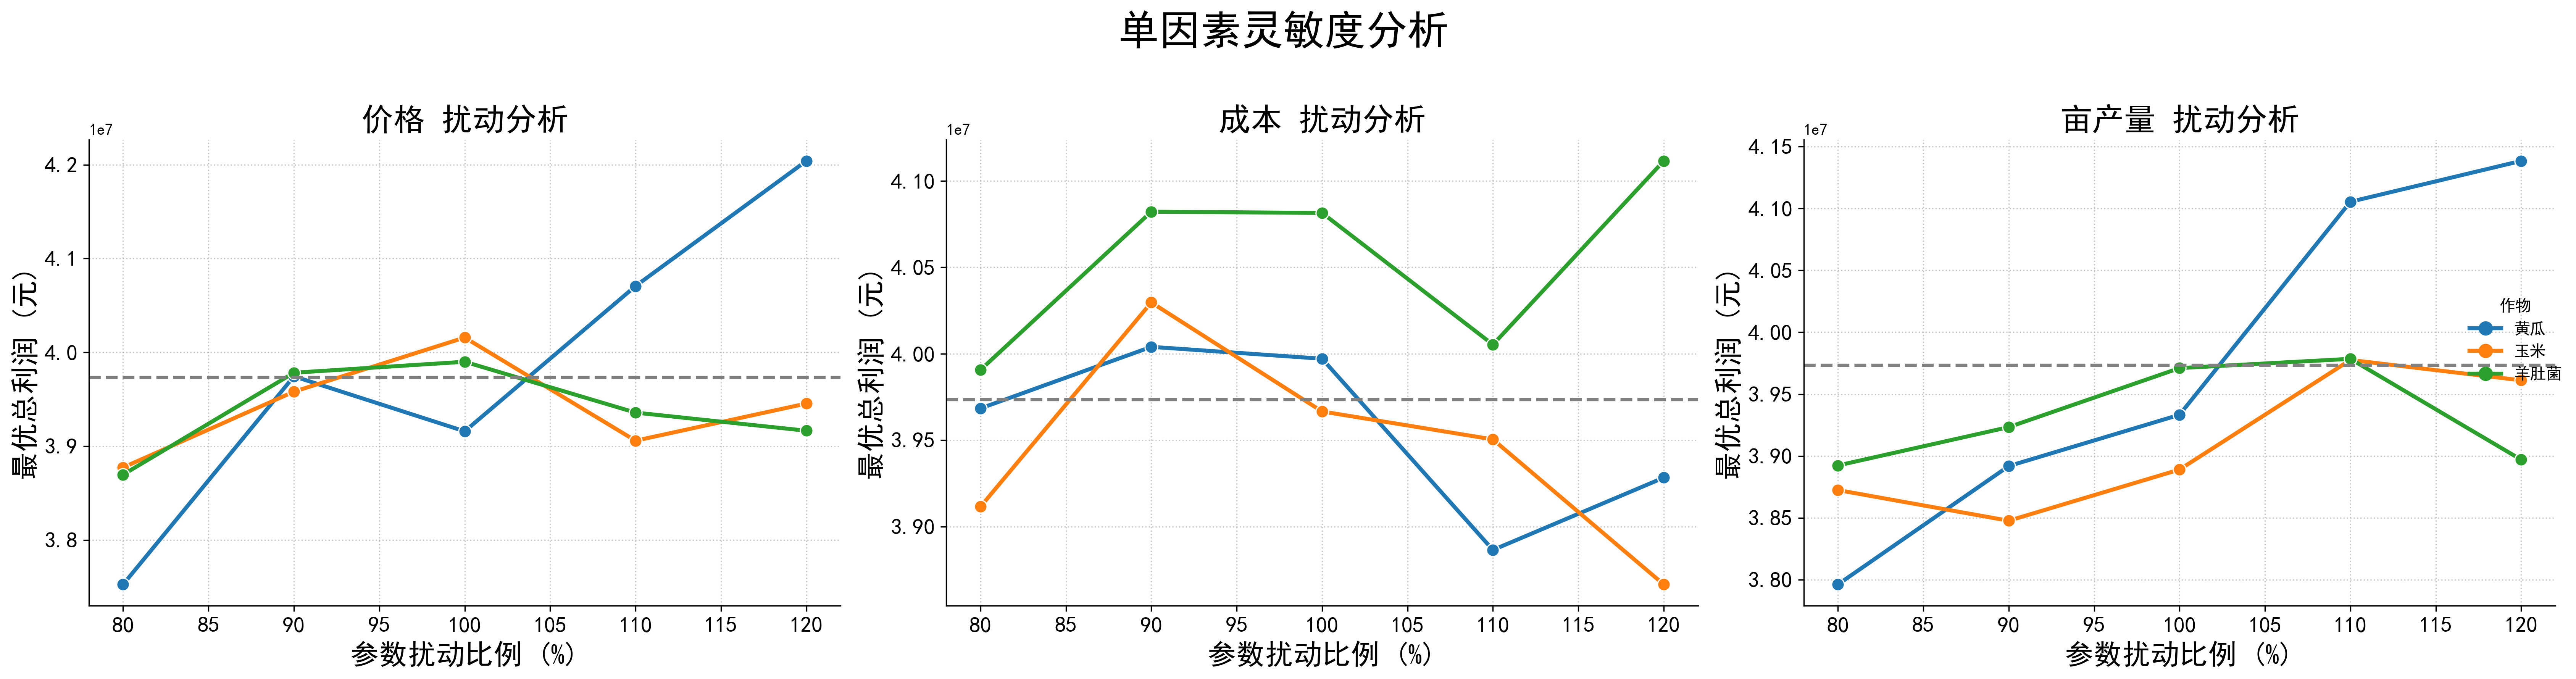

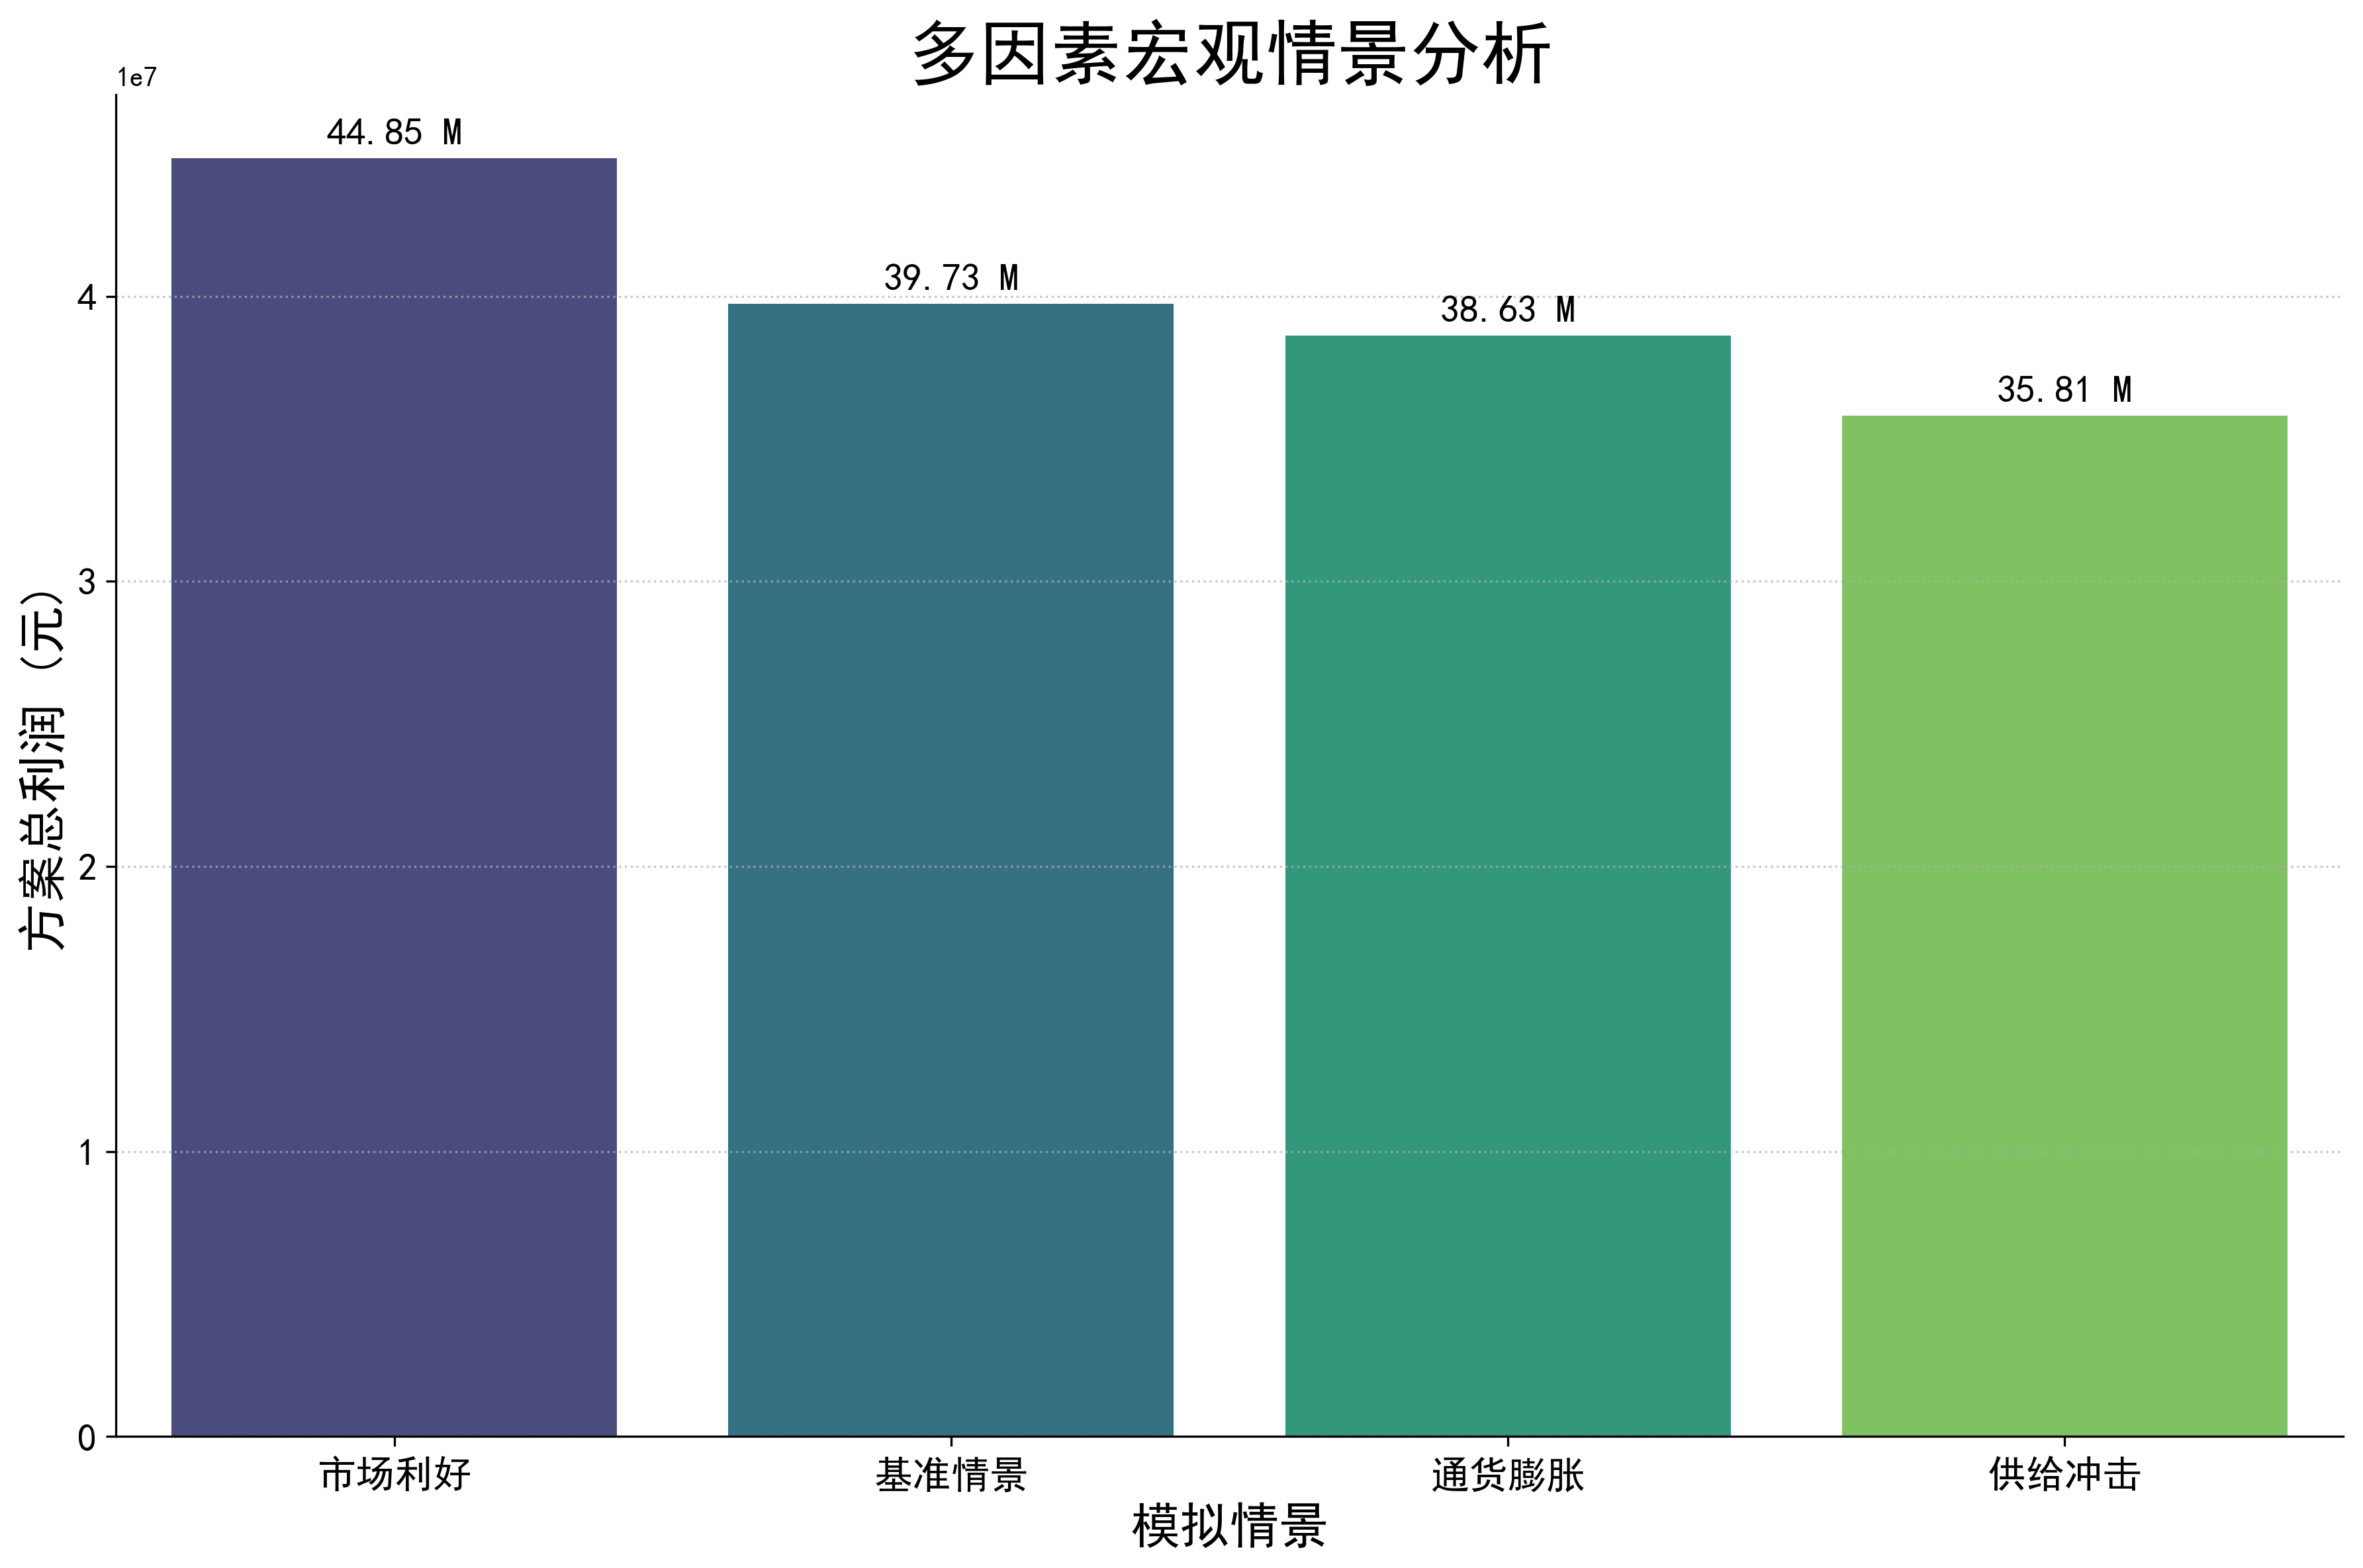

In [4]:
# 文件名: 1_plot_q1_sensitivity_figure.py
# 功能: 读取问题一分析数据，绘制单因素和多因素灵敏度分析图

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 1. 绘图配置区 ---
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300

# 定义字号
SUPER_TITLE_FONT_SIZE = 26
TITLE_FONT_SIZE = 20
LABEL_FONT_SIZE = 18
TICK_FONT_SIZE = 14
LEGEND_FONT_SIZE = 14

# --- 2. 主绘图程序 ---
if __name__ == '__main__':
    # 定义输入文件路径
    sf_data_file = Path('./Result/single_factor_sensitivity_results.csv')
    sc_data_file = Path('./Result/multi_factor_scenario_results.csv')
    output_dir = Path('./Result/')
    output_dir.mkdir(parents=True, exist_ok=True)

    # --- (1) 绘制单因素灵敏度分析图 ---
    if not sf_data_file.exists():
        print(f"错误: 未找到单因素分析数据文件 {sf_data_file}。")
    else:
        print(f"--- 正在读取单因素分析数据: {sf_data_file} ---")
        df_sf = pd.read_csv(sf_data_file)
        
        # 找到基准利润 (扰动比例为100%时的利润)
        # 我们假设所有作物在100%时的利润都应相同，取平均值以防万一
        base_profit = df_sf[df_sf['扰动比例(%)'] == 100]['最优总利润(元)'].mean()

        print(f"--- 正在绘制单因素灵敏度分析图 (基准利润: {base_profit:,.2f} 元) ---")
        
        # 使用seaborn的relplot创建分面网格图，效果最好
        g = sns.relplot(
            data=df_sf,
            x='扰动比例(%)',
            y='最优总利润(元)',
            hue='作物',
            col='参数类型',
            kind='line',
            lw=2.5,
            marker='o',
            markersize=8,
            height=6, 
            aspect=1.2,
            facet_kws=dict(sharey=False) # 让每个子图的Y轴独立
        )
        
        # 对每个子图进行美化
        for ax in g.axes.flat:
            ax.axhline(y=base_profit, color='grey', linestyle='--', linewidth=2, label='基准利润')
            ax.grid(True, linestyle=':', alpha=0.7)
            ax.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)
            ax.set_xlabel('参数扰动比例 (%)', fontsize=LABEL_FONT_SIZE)
            ax.set_ylabel('最优总利润 (元)', fontsize=LABEL_FONT_SIZE)

        # 设置图例和标题
        g.fig.suptitle('单因素灵敏度分析', fontsize=SUPER_TITLE_FONT_SIZE, weight='bold')
        g.set_titles("{col_name} 扰动分析", size=TITLE_FONT_SIZE)
        g.tight_layout(rect=[0, 0, 1, 0.95])
        
        # 保存图表
        save_file_sf = output_dir / "单因素灵敏度分析图.png"
        g.savefig(save_file_sf)
        print(f"-> 单因素分析图已保存至: {save_file_sf}")


    # --- (2) 绘制多因素情景分析图 ---
    if not sc_data_file.exists():
        print(f"错误: 未找到多因素情景分析数据文件 {sc_data_file}。")
    else:
        print(f"\n--- 正在读取多因素情景分析数据: {sc_data_file} ---")
        df_sc = pd.read_csv(sc_data_file)
        
        # 将基准利润作为一个情景添加进去，便于对比
        base_profit_df = pd.DataFrame([{'情景': '基准情景', '总利润(元)': base_profit}])
        df_sc = pd.concat([base_profit_df, df_sc], ignore_index=True).sort_values('总利润(元)', ascending=False)
        
        print("--- 正在绘制多因素情景分析图 ---")
        
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(data=df_sc, x='情景', y='总利润(元)', palette='viridis')

        # 添加数据标签
        for p in ax.patches:
            profit_in_million = p.get_height() / 1_000_000
            ax.annotate(f'{profit_in_million:.2f} M',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points',
                        fontsize=TICK_FONT_SIZE, weight='bold')

        # 美化
        ax.set_title('多因素宏观情景分析', fontsize=SUPER_TITLE_FONT_SIZE, weight='bold')
        ax.set_xlabel('模拟情景', fontsize=LABEL_FONT_SIZE)
        ax.set_ylabel('方案总利润 (元)', fontsize=LABEL_FONT_SIZE)
        ax.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        
        # 保存图表
        save_file_sc = output_dir / "多因素情景分析图.png"
        plt.savefig(save_file_sc)
        print(f"-> 多因素情景分析图已保存至: {save_file_sc}")
        
        plt.show()